<a href="https://colab.research.google.com/github/antoniomoricca/gym-reviews-nlp/blob/main/Gym_reviews_NLP_Anlasys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gym Reviews Analysis - NLP

This project applies various Natural Language Processing (NLP) techniques to analyze real customer reviews collected from Google and Trustpilot, focusing on a major gym chain. The objective is to uncover key topics, sentiment trends, and the underlying reasons behind negative feedback, with the goal of improving the overall member experience.

The analysis combines multiple approaches for topic modeling and sentiment analysis, including:

- Gensim for classical topic modeling

- BERTopic for semantic clustering

- Large Language Models (LLMs) for deep contextual understanding

By comparing traditional NLP methods with modern LLM-based approaches, the project highlights differences in topic extraction and insight depth. Sentiment analysis further identifies emotionally charged reviews to surface pain points and dissatisfaction drivers.

Ultimately, the project aims to provide actionable insights that can guide targeted improvements in customer satisfaction and retention.

The notebooke is structered in this way:

1. Libraries import
2. Dataset Load
3. Dataset EDA, text preprocessing pipeline, words frequency distribution and wordclouds
4. BERTopic modelling
5. Sentiment Analysis
6. Topic analysis using a LLM
7. Gensim
8. Final Conclusion

# Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import string
import re
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForCausalLM, pipeline
from langdetect import detect
import torch
import json
import pickle
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from transformers import pipeline
from bertopic import BERTopic
from nltk.stem.wordnet import WordNetLemmatizer
import string

# Dataset Load

In [ ]:
file1 = "/path_to_your_excel_file/google_rev.xlsx"
file2 = "/path_to_your_excel_file/trustp_rev.xlsx"


google_rev = pd.read_excel(file1)
trustp_rev = pd.read_excel(file2)


Mounted at /content/drive


In [ ]:
google_rev.head()

Customer Name SurveyID for external use (e.g. tech support)  \
0            **                      ekkt2vyxtkwrrrfyzc5hz6rk   
1            **                      e9b62vyxtkwrrrfyzc5hz6rk   
2            **                      e2dkxvyxtkwrrrfyzc5hz6rk   
3            **                      e3tfxvyxtkwrrrfyzc5hz6rk   
4            **                      edkrxvyxtkwrrrfyzc5hz6rk   

                         Club's Name Social Media Source       Creation Date  \
0            Leeds City Centre North      Google Reviews 2024-05-09 23:49:18   
1             Cambridge Leisure Park      Google Reviews 2024-05-09 22:48:39   
2                     London Holborn      Google Reviews 2024-05-09 22:08:14   
3  Cheshunt Brookfield Shopping Park      Google Reviews 2024-05-09 21:58:07   
4                 Bristol Union Gate      Google Reviews 2024-05-09 21:48:00   

                                             Comment  Overall Score  
0                                                NaN              4  
1  Too many students from two local colleges go h...              1  
2  Best range of equipment, cheaper than regular ...              5  
3  Good gym when it’s not busy, tend to get too b...              4  
4  (current member)\n\nGym is quite dirty, more o...              1

In [ ]:
google_rev.columns

Index(['Customer Name', 'SurveyID for external use (e.g. tech support)',
       'Club's Name', 'Social Media Source', 'Creation Date', 'Comment',
       'Overall Score'],
      dtype='object')

A new df is created to have just the important columns

In [ ]:
google_rev_clean = google_rev[["Club's Name", 'Creation Date','Comment','Overall Score']]

In [ ]:
google_rev_clean.head()

Club's Name       Creation Date  \
0            Leeds City Centre North 2024-05-09 23:49:18   
1             Cambridge Leisure Park 2024-05-09 22:48:39   
2                     London Holborn 2024-05-09 22:08:14   
3  Cheshunt Brookfield Shopping Park 2024-05-09 21:58:07   
4                 Bristol Union Gate 2024-05-09 21:48:00   

                                             Comment  Overall Score  
0                                                NaN              4  
1  Too many students from two local colleges go h...              1  
2  Best range of equipment, cheaper than regular ...              5  
3  Good gym when it’s not busy, tend to get too b...              4  
4  (current member)\n\nGym is quite dirty, more o...              1

In [ ]:
google_rev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23250 entries, 0 to 23249
Data columns (total 7 columns):
 #   Column                                         Non-Null Count  Dtype         
---  ------                                         --------------  -----         
 0   Customer Name                                  23250 non-null  object        
 1   SurveyID for external use (e.g. tech support)  23250 non-null  object        
 2   Club's Name                                    23250 non-null  object        
 3   Social Media Source                            23250 non-null  object        
 4   Creation Date                                  23250 non-null  datetime64[ns]
 5   Comment                                        13898 non-null  object        
 6   Overall Score                                  23250 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 1.2+ MB


For the goal of this project all the rows with no comment will be discarded.

In [ ]:
google_rev_clean = google_rev_clean.dropna(subset=['Comment'])

In [ ]:
google_rev_clean.head()

Club's Name       Creation Date  \
1             Cambridge Leisure Park 2024-05-09 22:48:39   
2                     London Holborn 2024-05-09 22:08:14   
3  Cheshunt Brookfield Shopping Park 2024-05-09 21:58:07   
4                 Bristol Union Gate 2024-05-09 21:48:00   
5       209 - Slagelse, Jernbanegade 2024-05-09 21:36:17   

                                             Comment  Overall Score  
1  Too many students from two local colleges go h...              1  
2  Best range of equipment, cheaper than regular ...              5  
3  Good gym when it’s not busy, tend to get too b...              4  
4  (current member)\n\nGym is quite dirty, more o...              1  
5  Kom og betalte for en prøvetime i centret. Fik...              1

In [ ]:
trustp_rev.head()

Review ID Review Created (UTC)   Review Consumer User ID  \
0  663d40378de0a14c26c2f63c  2024-05-09 23:29:00  663d4036d5fa24c223106005   
1  663d3c101ccfcc36fb28eb8c  2024-05-09 23:11:00  5f5e3434d53200fa6ac57238   
2  663d375859621080d08e6198  2024-05-09 22:51:00  57171ba90000ff000a18f905   
3  663d4fa1f25670a3339ccf6d  2024-05-09 22:35:00  663d4fa0d5fa24251d1068e7   
4  663d3251d8367b7b3c4ace64  2024-05-09 22:30:00  60c20598384d84001a4250de   

                    Review Title  \
0        A very good environment   
1  I love to be part of this gym   
2                 Extremely busy   
3                    Great vibes   
4      Everything it needs to be   

                                      Review Content  Review Stars  \
0                            A very good environment             5   
1  I love to be part of this gym. Superb value fo...             5   
2                      Extremely busy, no fresh air.             1   
3                         Great vibes, fantastic gym             5   
4             Clean, well managed, classes are good.             5   

  Source Of Review Review Language              Domain URL Webshop Name  \
0            AFSv2              en  http://www.puregym.com   PureGym UK   
1            AFSv2              en  http://www.puregym.com   PureGym UK   
2            AFSv2              en  http://www.puregym.com   PureGym UK   
3            AFSv2              en  http://www.puregym.com   PureGym UK   
4            AFSv2              en  http://www.puregym.com   PureGym UK   

           Business Unit ID  Tags Company Reply Date (UTC)  \
0  508df4ea00006400051dd7b1   NaN      2024-05-10 08:12:00   
1  508df4ea00006400051dd7b1   NaN      2024-05-10 08:13:00   
2  508df4ea00006400051dd7b1   NaN                      NaT   
3  508df4ea00006400051dd7b1   NaN                      NaT   
4  508df4ea00006400051dd7b1   NaN      2024-05-10 08:14:00   

                Location Name                           Location ID  
0  Solihull Sears Retail Park  7b03ccad-4a9d-4a33-9377-ea5bba442dfc  
1                   Aylesbury  612d3f7e-18f9-492b-a36f-4a7b86fa5647  
2         Sutton Times Square  0b78c808-f671-482b-8687-83468b7b5bc1  
3             London Finchley  bc3a9a8c-defe-47b3-8ee6-f73a03b7447e  
4                    Crayford  9ce470b7-57df-4533-af2f-c539422fed14

In [ ]:
trustp_rev.columns

Index(['Review ID', 'Review Created (UTC)', 'Review Consumer User ID',
       'Review Title', 'Review Content', 'Review Stars', 'Source Of Review',
       'Review Language', 'Domain URL', 'Webshop Name', 'Business Unit ID',
       'Tags', 'Company Reply Date (UTC)', 'Location Name', 'Location ID'],
      dtype='object')

In [ ]:
trustp_rev_clean = trustp_rev[['Review Created (UTC)','Location Name','Review Content','Review Stars','Review Title','Review Language']]

In [ ]:
trustp_rev_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16673 entries, 0 to 16672
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Review Created (UTC)  16673 non-null  datetime64[ns]
 1   Location Name         11323 non-null  object        
 2   Review Content        16673 non-null  object        
 3   Review Stars          16673 non-null  int64         
 4   Review Title          16673 non-null  object        
 5   Review Language       16673 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 781.7+ KB


In [ ]:
trustp_rev_clean['Review Language'].unique()

array(['en', 'it', 'da', 'pl', 'bg', 'ar', 'pt', 'ro', 'es', 'fr', 'sco',
       'sk', 'st', 'de', 'et', 'sv', 'lt', 'ru', 'uk', 'tr'], dtype=object)

In [ ]:
trustp_rev_clean = trustp_rev_clean[trustp_rev_clean['Review Language'] == 'en']

All the non english review are discarder. It has no impact since they are a small portion of the entire dataset.

In [ ]:
trustp_rev_clean.shape

(16581, 6)

# Dataset EDA and PreProcessing Pipeline

In this section some dataset investigation are carried out

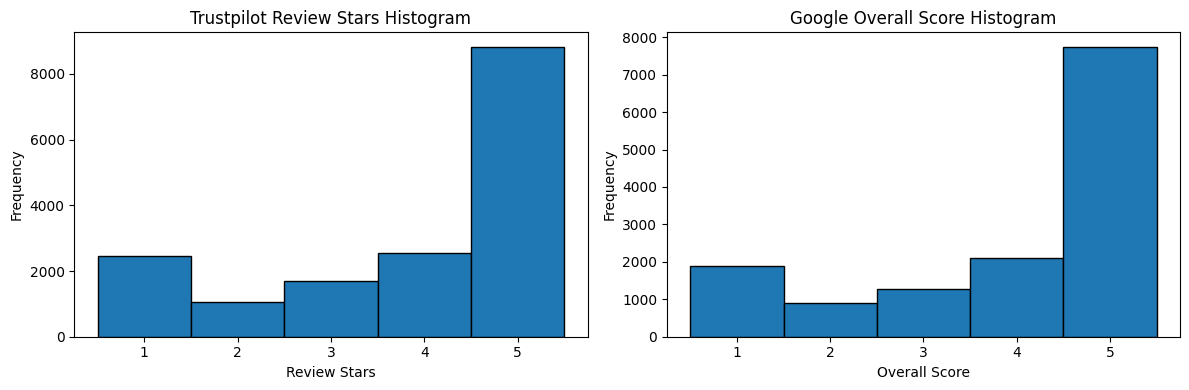

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(trustp_rev_clean['Review Stars'], bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], edgecolor='black')
axes[0].set_title('Trustpilot Review Stars Histogram')
axes[0].set_xlabel('Review Stars')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks([1, 2, 3, 4, 5])

axes[1].hist(google_rev_clean['Overall Score'], bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], edgecolor='black')
axes[1].set_title('Google Overall Score Histogram')
axes[1].set_xlabel('Overall Score')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks([1, 2, 3, 4, 5])

plt.tight_layout()
plt.show()


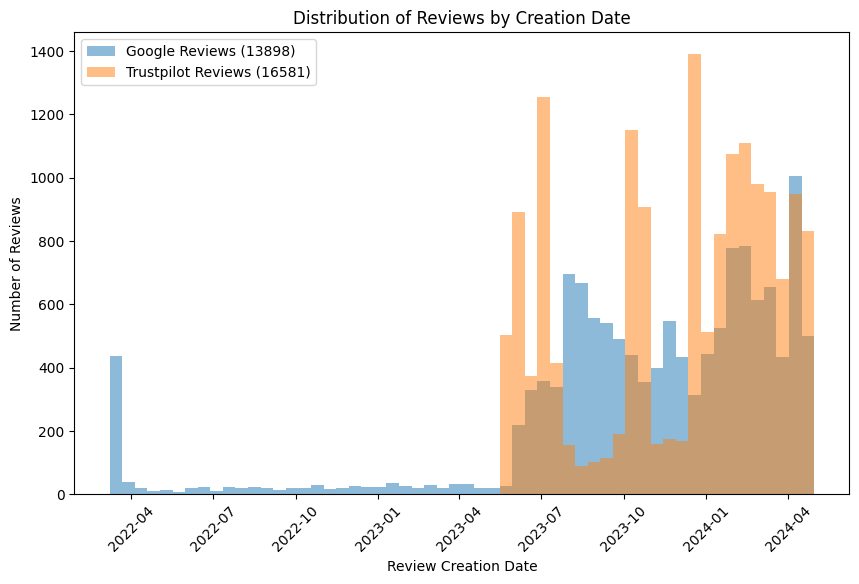

In [ ]:
google_rev_clean['Creation Date'] = pd.to_datetime(google_rev_clean['Creation Date'])
trustp_rev_clean['Review Created (UTC)'] = pd.to_datetime(trustp_rev_clean['Review Created (UTC)'])

start_date = min(google_rev_clean['Creation Date'].min(), trustp_rev_clean['Review Created (UTC)'].min())
end_date = max(google_rev_clean['Creation Date'].max(), trustp_rev_clean['Review Created (UTC)'].max())

bin_edges = pd.date_range(start=start_date, end=end_date, freq='14D')

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(google_rev_clean['Creation Date'], bins=bin_edges, alpha=0.5, label=f'Google Reviews ({len(google_rev_clean)})', align='mid')
ax.hist(trustp_rev_clean['Review Created (UTC)'], bins=bin_edges, alpha=0.5, label=f'Trustpilot Reviews ({len(trustp_rev_clean)})', align='mid')

ax.set_xlabel('Review Creation Date')
ax.set_ylabel('Number of Reviews')
ax.set_title('Distribution of Reviews by Creation Date')
ax.legend()
plt.xticks(rotation=45)

plt.show()


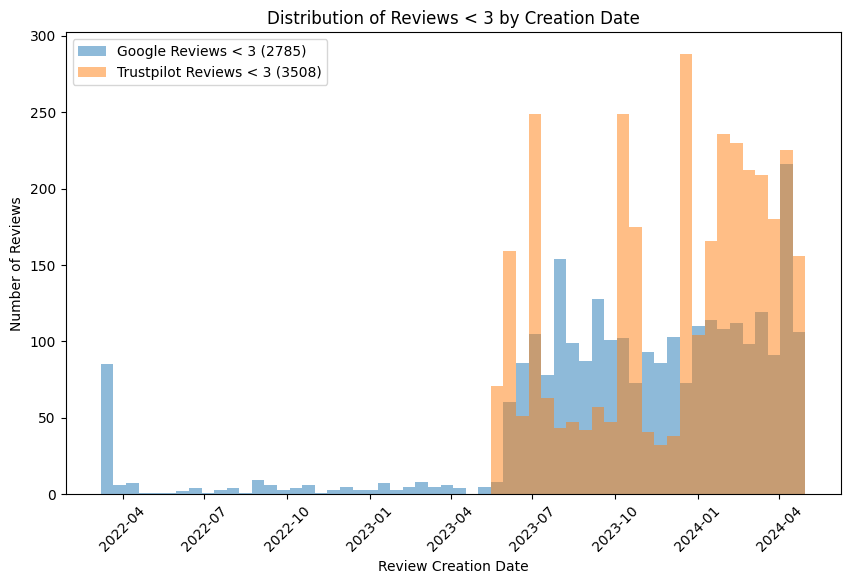

In [ ]:
google_rev_low = google_rev_clean[google_rev_clean['Overall Score'] < 3]
trustp_rev_low = trustp_rev_clean[trustp_rev_clean['Review Stars'] < 3]

start_date = min(google_rev_low['Creation Date'].min(), trustp_rev_low['Review Created (UTC)'].min())
end_date = max(google_rev_low['Creation Date'].max(), trustp_rev_low['Review Created (UTC)'].max())

bin_edges = pd.date_range(start=start_date, end=end_date, freq='14D')

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(google_rev_low['Creation Date'], bins=bin_edges, alpha=0.5, label=f'Google Reviews < 3 ({len(google_rev_low)})', align='mid')
ax.hist(trustp_rev_low['Review Created (UTC)'], bins=bin_edges, alpha=0.5, label=f'Trustpilot Reviews < 3 ({len(trustp_rev_low)})', align='mid')

ax.set_xlabel('Review Creation Date')
ax.set_ylabel('Number of Reviews')
ax.set_title('Distribution of Reviews < 3 by Creation Date')
ax.legend()
plt.xticks(rotation=45)

plt.show()


In [ ]:
print('Number of unique location in the Google rev dataset are:', google_rev_clean['Club\'s Name'].nunique())
print('Number of unique location in the Trustpilot rev dataset are:', trustp_rev_clean['Location Name'].nunique())


Number of unique location in the Google rev dataset are: 512
Number of unique location in the Trustpilot rev dataset are: 376


In [ ]:
common_location = set(google_rev_clean['Club\'s Name']).intersection(trustp_rev_clean['Location Name'])
print('Number of common location are:', len(common_location))

Number of common location are: 310


In this process, we will perform text preprocessing on a specific columns of the dataset. The steps include:

1. Removing Numbers – Eliminating any numerical values to keep only textual information.
2. Converting to Lowercase – Standardizing the text by converting all characters to lowercase.
3. Removing Stopwords – Filtering out common words (e.g., "the", "is", "and") using NLTK's stopword list to focus on meaningful terms.
4. Tokenization – Splitting the text into individual words using word_tokenize from the NLTK library.

This function ensures the text is cleaned and structured for further natural language processing tasks.

In [ ]:
def preprocess_text(text):
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    return tokens

A new column for each df is created, apply the preprocessing function to the Comment/Review column

In [ ]:
google_rev_clean['Comment_tk'] = google_rev_clean['Comment'].apply(preprocess_text)

In [ ]:
trustp_rev_clean['Comment_tk'] = trustp_rev_clean['Review Content'].apply(preprocess_text)

In [ ]:
google_rev_clean.iloc[0]['Comment_tk'],google_rev_clean.iloc[0]['Comment']

(['many',
  'students',
  'two',
  'local',
  'colleges',
  'go',
  'leave',
  'rubbish',
  'changing',
  'rooms',
  'sit',
  'like',
  'canteen',
  '.',
  'going',
  'years',
  'cancel',
  'membership',
  'go',
  'gym',
  'group',
  '.',
  'gym',
  'disgusting',
  'students',
  'hanging',
  'around',
  'machines',
  'messing',
  'around',
  'like',
  'school',
  '.',
  'crowded',
  '.',
  '(',
  'ceo',
  'supports',
  'genocide',
  'civilians',
  'israel',
  ')',
  '.',
  'disgusting',
  'people',
  '!',
  '!'],
 'Too many students from two local colleges go her leave rubbish in changing rooms and sit there like there in a canteen. Been going here for 5 years will cancel my membership and go to gym group. This gym is disgusting students hanging around machines and messing around like there at school. Too over crowded.( And their ceo supports the genocide of civilians by Israel). Disgusting people!!')

In [ ]:
trustp_rev_clean.iloc[1]['Comment_tk'],trustp_rev_clean.iloc[1]['Review Content']

(['love',
  'part',
  'gym',
  '.',
  'superb',
  'value',
  'money',
  '.',
  'time',
  ',',
  'day',
  '.',
  'love',
  'app',
  ',',
  'well',
  'organised',
  'building',
  'equipment',
  ',',
  'studio',
  'area',
  ',',
  'cycling',
  'area',
  'important',
  'feel',
  'safe',
  '.'],
 'I love to be part of this gym. Superb value for money. Any time, any day. Love the app too, well organised building equipment, studio area, cycling area and more important feel safe.')

## WordClouds and Words Frequency Distributions


In this part a calculation of the most frequent words on the 2 dataset

In [ ]:
extra_stopwords = {'’', "'s","n't"} # I add these extra stopwords cause '’' is not included in the string.punctuation - "'s"
all_words_google = [word for tokens in google_rev_clean["Comment_tk"] for word in tokens if word not in string.punctuation and word.lower() not in extra_stopwords]
freq_dist_google = FreqDist(all_words_google)
top_10_words_google = [word for word, _ in freq_dist_google.most_common(10)]
print(top_10_words_google)


['gym', 'equipment', 'great', 'good', 'staff', 'classes', 'clean', 'friendly', 'machines', 'always']


In [ ]:
extra_stopwords = {'’', "'s","n't"} # I add these extra stopwords cause '’' is not included in the string.punctuation - "'s"
all_words_trustp = [word for tokens in trustp_rev_clean["Comment_tk"] for word in tokens if word not in string.punctuation and word.lower() not in extra_stopwords]
freq_dist_trustp = FreqDist(all_words_trustp)
top_10_words_trustp = [word for word, _ in freq_dist_trustp.most_common(10)]
print(top_10_words_trustp)

['gym', 'equipment', 'good', 'great', 'staff', 'clean', 'friendly', 'classes', 'easy', 'really']


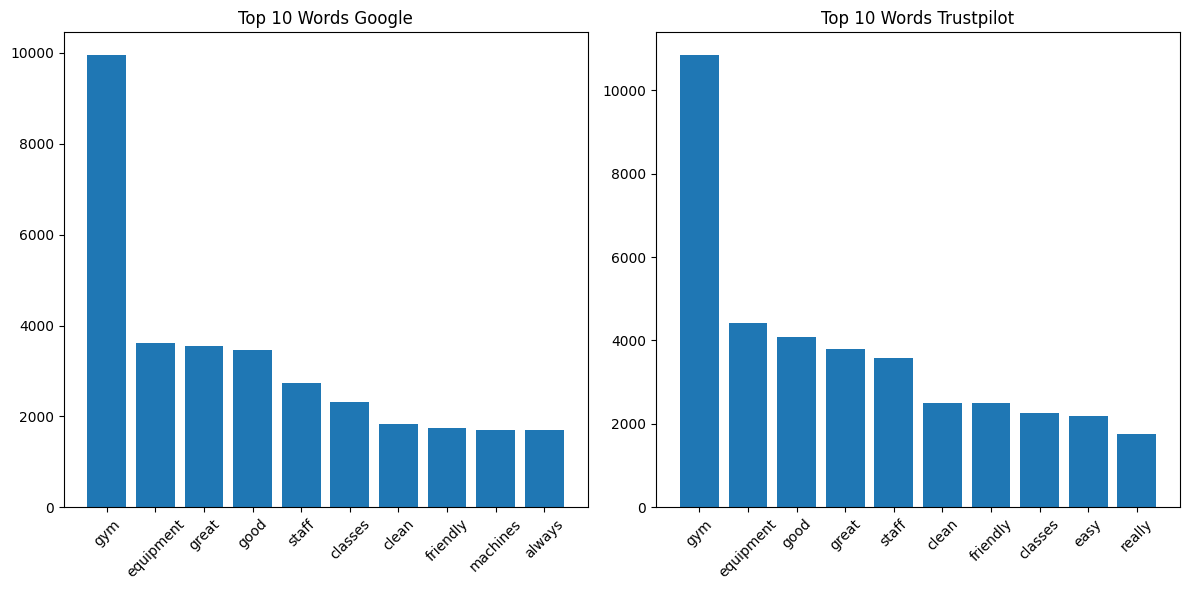

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].bar(top_10_words_google, [freq_dist_google[word] for word in top_10_words_google])
axes[0].set_title('Top 10 Words Google')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(top_10_words_trustp, [freq_dist_trustp[word] for word in top_10_words_trustp])
axes[1].set_title('Top 10 Words Trustpilot')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


A function is define to create and display a word cloud

In [ ]:
def word_cloud_display(review_list):
  plt.figure(figsize=(12, 8))
  wc = WordCloud(background_color = 'black', max_words = 1000,  max_font_size = 50,collocations=False)
  wc.generate(' '.join(review_list))
  plt.imshow(wc)
  plt.axis('off')

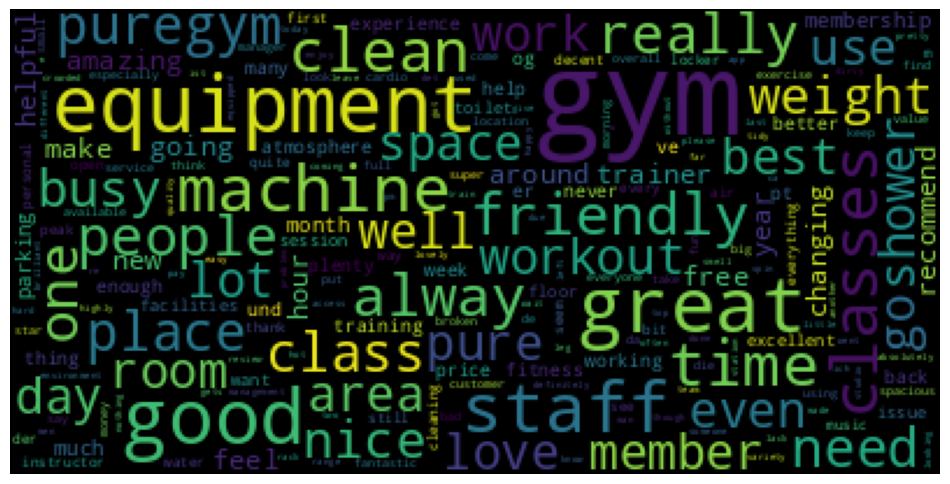

In [ ]:
word_cloud_display(all_words_google)

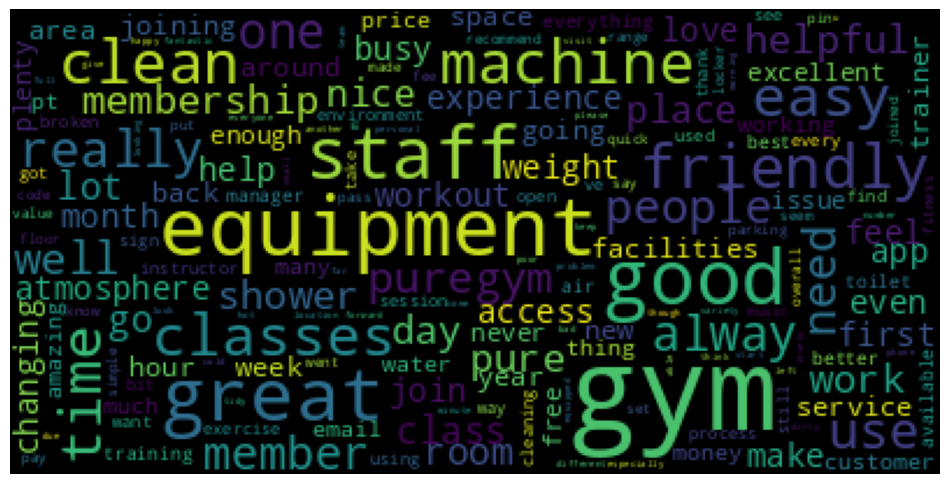

In [ ]:
word_cloud_display(all_words_trustp)

The word clouds and frequency distributions indicate that the most frequent words in both datasets are either generic (e.g., "gym") or positive (e.g., "good," "great"). Additionally, the results are quite similar across the two datasets, suggesting a consistent trend in the reviews. That is probably due to the presence of a lot of good reviews.

Now, the same calculations are performed, but filtering only negative reviews, which are those with fewer than 3 stars in both datasets. This to understand which are the most recurrent words in the negative reviews.









In [ ]:
negative_google_rev = google_rev_clean[google_rev_clean['Overall Score'] < 3].copy()
negative_trustp_rev = trustp_rev_clean[trustp_rev_clean['Review Stars'] < 3].copy()

In [ ]:
negative_google_rev.head()

Club's Name       Creation Date  \
1         Cambridge Leisure Park 2024-05-09 22:48:39   
4             Bristol Union Gate 2024-05-09 21:48:00   
5   209 - Slagelse, Jernbanegade 2024-05-09 21:36:17   
7                     New Barnet 2024-05-09 20:16:04   
19      Manchester Cheetham Hill 2024-05-09 17:03:50   

                                              Comment  Overall Score  \
1   Too many students from two local colleges go h...              1   
4   (current member)\n\nGym is quite dirty, more o...              1   
5   Kom og betalte for en prøvetime i centret. Fik...              1   
7   This gym is way too hot to even workout in. Th...              2   
19  No access for wc 😢.  Empty and no assistance t...              2   

                                           Comment_tk  
1   [many, students, two, local, colleges, go, lea...  
4   [(, current, member, ), gym, quite, dirty, ,, ...  
5   [kom, og, betalte, en, prøvetime, centret, ., ...  
7   [gym, way, hot, even, workout, ., windows, ope...  
19  [access, wc, 😢, ., empty, assistance, gain, ac...

In [ ]:
negative_trustp_rev.head()

Review Created (UTC)            Location Name  \
2   2024-05-09 22:51:00      Sutton Times Square   
19  2024-05-09 18:09:00  Leeds City Centre South   
35  2024-05-09 13:25:00                      NaN   
36  2024-05-09 13:17:00                      NaN   
38  2024-05-09 12:35:00                      NaN   

                                       Review Content  Review Stars  \
2                       Extremely busy, no fresh air.             1   
19  The men’s changing rooms smell bad. They need ...             2   
35  All I wanted to do was set up another debit ca...             1   
36  What ever you do don’t downgrade your membersh...             1   
38  Poor parking, not enough kit, unhelpful traine...             2   

                              Review Title Review Language  \
2                           Extremely busy              en   
19      The men’s changing rooms smell bad              en   
35  All I wanted to do was set up another…              en   
36  What ever you do don’t downgrade your…              en   
38                              Awful Gyms              en   

                                           Comment_tk  
2                 [extremely, busy, ,, fresh, air, .]  
19  [men, ’, changing, rooms, smell, bad, ., need,...  
35  [wanted, set, another, debit, card, direct, de...  
36  [ever, ’, downgrade, membership, core, plus…, ...  
38  [poor, parking, ,, enough, kit, ,, unhelpful, ...

In [ ]:
extra_stopwords = {'’', "'s","n't"} # I add these extra stopwords cause '’' is not included in the string.punctuation
all_words_google_neg = [word for tokens in negative_google_rev["Comment_tk"] for word in tokens if word not in string.punctuation and  len(word)>2 and word.lower() not in extra_stopwords]
freq_dist_google_neg = FreqDist(all_words_google_neg)
top_10_words_google_neg = [word for word, _ in freq_dist_google_neg.most_common(10)]
print(top_10_words_google_neg)

['gym', 'equipment', 'staff', 'people', 'machines', 'one', 'time', 'get', 'like', 'even']


In [ ]:
extra_stopwords = {'’', "'s","n't"} # I add these extra stopwords cause '’' is not included in the string.punctuation - "'s"
all_words_trustp_neg = [word for tokens in negative_trustp_rev["Comment_tk"] for word in tokens if word not in string.punctuation and  len(word)>2 and word.lower() not in extra_stopwords]
freq_dist_trustp_neg = FreqDist(all_words_trustp_neg)
top_10_words_trustp_neg = [word for word, _ in freq_dist_trustp_neg.most_common(10)]
print(top_10_words_trustp_neg)

['gym', 'equipment', 'membership', 'get', 'one', 'staff', 'time', 'use', 'people', 'machines']


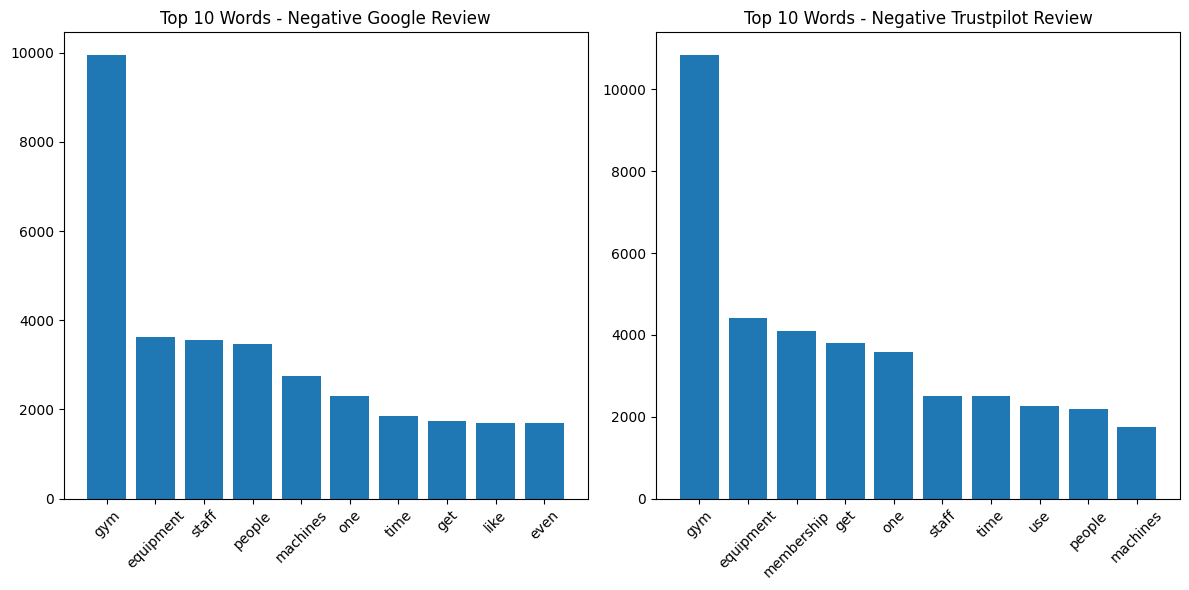

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].bar(top_10_words_google_neg, [freq_dist_google[word] for word in top_10_words_google])
axes[0].set_title('Top 10 Words - Negative Google Review')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(top_10_words_trustp_neg, [freq_dist_trustp[word] for word in top_10_words_trustp])
axes[1].set_title('Top 10 Words - Negative Trustpilot Review')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

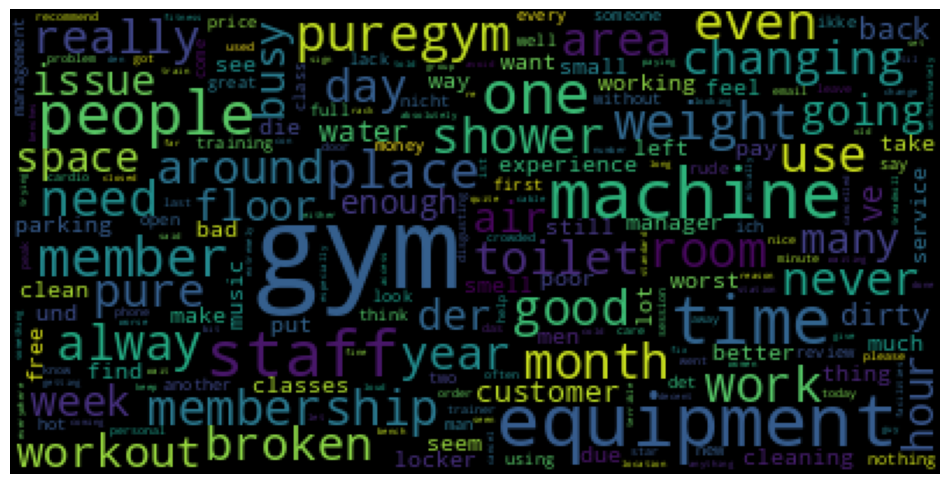

In [ ]:
word_cloud_display(all_words_google_neg)

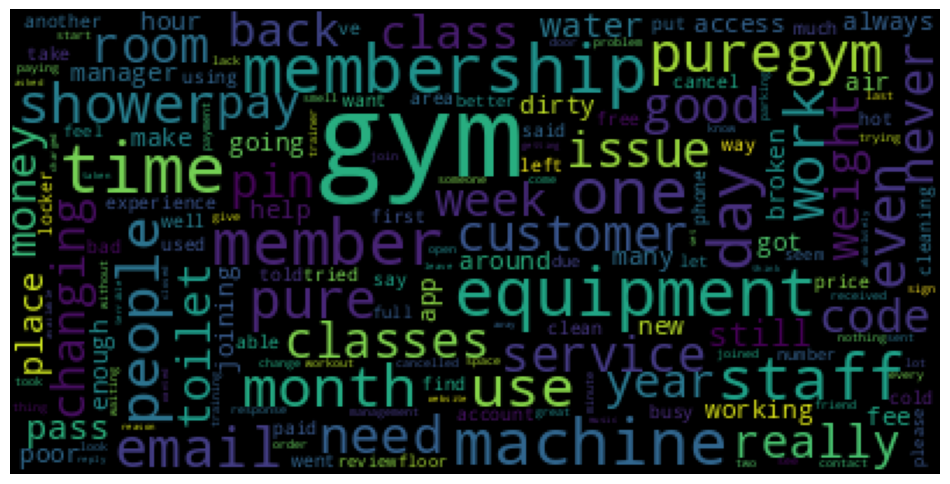

In [ ]:
word_cloud_display(all_words_trustp_neg)

After filtering the datasets, the most common words have changed slightly. On one hand, some negative terms have emerged (e.g., "issue," "broken"), while on the other, certain words related to potentially problematic topics, such as "payment" and "membership," have started to appear. However, the top ten words do not provide any significant insights since they are pretty generic. A deeper investigation is required.

# BertTopic Modelling

In thi section, BERTopic is used to extract the recurrent topic on the negative reviews.

For this purpose, the reviews coming from the 2 datasets are merged into a list which contains the bad reviews that belongs to the same location.

In [ ]:
negative_g_common_location = negative_google_rev[negative_google_rev['Club\'s Name'].isin(common_location)].copy()
negative_t_common_location = negative_trustp_rev[negative_trustp_rev['Location Name'].isin(common_location)].copy()

negative_g_common_location['Comment'] = negative_g_common_location['Comment'].astype(str)
negative_t_common_location['Review Content'] = negative_t_common_location['Review Content'].astype(str)

negative_g_common_location_list = negative_g_common_location['Comment'].to_list()
negative_t_common_location_list = negative_t_common_location['Review Content'].to_list()

negative_reviews_list = negative_g_common_location_list + negative_t_common_location_list

In [ ]:
negative_reviews_list[0]

'Too many students from two local colleges go her leave rubbish in changing rooms and sit there like there in a canteen. Been going here for 5 years will cancel my membership and go to gym group. This gym is disgusting students hanging around machines and messing around like there at school. Too over crowded.( And their ceo supports the genocide of civilians by Israel). Disgusting people!!'

Now the list is created, and it has to be clean before using the BERTopic

In [ ]:
negative_reviews_list_clean = []

for review in negative_reviews_list:
  if review is not None and review != "nan":
    review = review.lower()
    review = re.sub('[^A-Za-z]+', ' ', review)
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(review)

    for w in word_tokens:
      if w in stop_words:
        review = review.replace(" " + w + " ", " ")
    negative_reviews_list_clean.append(review)

In [ ]:
negative_reviews_list_clean[0]

'too many students two local colleges go leave rubbish changing rooms sit like canteen going years cancel membership go gym group gym disgusting students hanging around machines messing around like school crowded ceo supports genocide civilians israel disgusting people '

Here the BERTopic pretrained model is installed

In [ ]:
model = BERTopic(verbose=True)
model.fit(negative_reviews_list_clean)
topic, probabilities = model.transform(negative_reviews_list_clean)
topic = model.reduce_outliers(negative_reviews_list_clean, topic) # This command to reduce the high number of outliers
model.update_topics(negative_reviews_list_clean, topics=topic)

2025-03-22 15:14:21,116 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/124 [00:00<?, ?it/s]

2025-03-22 15:14:24,782 - BERTopic - Embedding - Completed ✓
2025-03-22 15:14:24,784 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-22 15:14:49,011 - BERTopic - Dimensionality - Completed ✓
2025-03-22 15:14:49,012 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-22 15:14:49,154 - BERTopic - Cluster - Completed ✓
2025-03-22 15:14:49,159 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-22 15:14:49,307 - BERTopic - Representation - Completed ✓


Batches:   0%|          | 0/124 [00:00<?, ?it/s]

2025-03-22 15:14:51,918 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-03-22 15:14:51,932 - BERTopic - Dimensionality - Completed ✓
2025-03-22 15:14:51,933 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-03-22 15:14:52,144 - BERTopic - Cluster - Completed ✓
100%|██████████| 2/2 [00:00<00:00,  3.28it/s]
2025-03-22 15:14:52,799 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


The method "reduce_outliers" has been used to reduce the total number of reviews that were not included in any other topic. This has improved the performance of the model.

In [ ]:
model.get_topic_info()

Topic  Count                                     Name  \
0      -1      1  -1_edificio_ruidoso_remodelaci_regadera   
1       0    248               0_air_conditioning_con_hot   
2       1    193                      1_pass_pin_code_day   
3       2    128                  2_parking_car_park_fine   
4       3    216                3_manager_gym_member_rude   
5       4    208          4_toilets_toilet_changing_rooms   
6       5    115                  5_music_loud_noise_hear   
7       6    133               6_closed_open_opening_days   
8       7    119           7_smell_smells_ventilation_bad   
9       8     97       8_equipment_equipments_busy_broken   
10      9    136            9_weights_weight_plates_bench   
11     10     73                10_never_es_there_rubbish   
12     11    127         11_cleaning_stations_sweat_clean   
13     12     79     12_rude_staff_manager_unprofessional   
14     13    106             13_water_machine_yanga_weeks   
15     14     82        14_class_classes_cancelled_booked   
16     15     93              15_showers_shower_fix_dirty   
17     16     68            16_locker_lockers_lock_stolen   
18     17     85             17_machines_broken_fix_order   
19     18    122            18_years_equipment_gym_broken   
20     19     53               19_wifi_signal_internet_wi   
21     20     87       20_membership_cancel_account_month   
22     21    124           21_machines_gym_equipment_good   
23     22     61                 22_worst_ever_london_gym   
24     23     62       23_cold_shower_temperature_showers   
25     24     70                24_showers_cold_water_hot   
26     25     68            25_machine_cable_machines_leg   
27     26     61          26_peak_impossible_busy_waiting   
28     27     71     27_changing_management_toilet_shower   
29     28     57           28_overcrowded_crowded_too_cap   
30     29     58              29_phones_kids_people_phone   
31     30     72         30_small_equipment_better_bigger   
32     31     52       31_classes_instructors_class_zumba   
33     32     41            32_dirty_cleaned_dust_toilets   
34     33     41          33_fee_joining_discount_charged   
35     34     27             34_lockers_locker_space_room   
36     35     43          35_kids_teenagers_groups_people   
37     36     58     36_busy_extremely_oversubscribed_too   
38     37     25              37_class_pt_classes_session   
39     38     30              38_women_men_section_ladies   
40     39     21          39_cold_showers_footprint_water   
41     40     34                 40_stars_give_would_star   
42     41     27           41_induction_booked_app_showed   
43     42     13          42_ceo_genocide_supports_israel   
44     43     36            43_email_app_response_contact   
45     44     34                    44_dirty_no_very_kits   
46     45     20         45_shower_showers_changing_rooms   
47     46     39            46_help_staff_minutes_outside   
48     47     30              47_linlithgow_gym_pure_bike   
49     48     27            48_plus_cancel_month_contract   
50     49     25             49_door_lift_broken_entrance   
51     50     15      50_client_protected_travel_receipts   
52     51     21                51_access_home_abbey_wood   
53     52     15            52_rules_bags_footwear_shirts   

                                       Representation  \
0   [edificio, ruidoso, remodelaci, regadera, expu...   
1   [air, conditioning, con, hot, aircon, summer, ...   
2   [pass, pin, code, day, access, get, paid, work...   
3   [parking, car, park, fine, free, fines, reg, t...   
4   [manager, gym, member, rude, staff, personal, ...   
5   [toilets, toilet, changing, rooms, always, dir...   
6   [music, loud, noise, hear, headphones, classes...   
7   [closed, open, opening, days, gym, christmas, ...   
8   [smell, smells, ventilation, bad, stinks, gym,...   
9   [equipment, equipments, busy, broken, enough, ...   
10  [weights, weight,

In [ ]:
model.get_topic_freq().head(10)

Topic  Count
2       0    248
10      3    216
11      4    208
3       1    193
32      9    136
27      6    133
25      2    128
18     11    127
13     21    124
33     18    122

In [ ]:
topic_freq = model.get_topic_freq()
for _, row in topic_freq.head(10).iterrows():
    topic_id = row['Topic']
    frequency = row['Count']
    name = model.get_topic(topic_id)
    print(f"Topic {topic_id} ({frequency}): {', '.join([word for word, _ in name[:3]])}")

Topic 0 (248): air, conditioning, con
Topic 3 (216): manager, gym, member
Topic 4 (208): toilets, toilet, changing
Topic 1 (193): pass, pin, code
Topic 9 (136): weights, weight, plates
Topic 6 (133): closed, open, opening
Topic 2 (128): parking, car, park
Topic 11 (127): cleaning, stations, sweat
Topic 21 (124): machines, gym, equipment
Topic 18 (122): years, equipment, gym


The extracted topics appear to be well-separated and each one points to a distinct issue frequently mentioned by customers. From equipment quality and air conditioning to cleanliness and staff behavior, the topics reflect a wide range of operational aspects. This suggests that customer feedback is focused on specific, tangible problems rather than general dissatisfaction, providing clear opportunities for targeted improvements across different areas of the business.

In [ ]:
topic_freq = model.get_topic_freq()
for _, row in topic_freq.head(2).iterrows():
    topic_id = row['Topic']
    frequency = row['Count']
    name = model.get_topic(topic_id)
    print(f"Topic {topic_id} ({frequency}): {', '.join([word for word, _ in name[:10]])}")

Topic 0 (248): air, conditioning, con, hot, aircon, summer, ac, heat, working, temperature
Topic 3 (216): manager, gym, member, rude, staff, personal, people, said, pt, help


Regarding the 2 most frequent topics, it seems that the first one is  really specific to the hot temperature and air conditioning of the gyms. The second one is more related to the staff member of the gym.

In [ ]:
model.visualize_topics()

The intertopic distance map shows that some topics share a high degree of semantic similarity and could be merged. However, others, although overlapping in the semantic space, represent distinct issues that happen to involve similar vocabulary. For this reason, no manual merging was performed, in order to preserve the nuance of each specific concern.

In [ ]:
model.visualize_barchart()

1. **Topic 0**: Focus on **air conditioning** issues, including terms like *air*, *conditioning*, *hot*, and *aircon*, suggesting complaints or mentions related to indoor climate.

2. **Topic 1**: Mentions related to **access methods**, with words like *pass*, *pin*, and *access*, possibly highlighting issues or comments about entering the facility.

3. **Topic 2**: Related to **parking**, with keywords like *parking*, *car*, *park*, and *fine*, likely indicating concerns about vehicle access or parking policies.

4. **Topic 3**: Reflects **staff or management behavior**, with terms like *manager*, *rude*, *staff*, and *member*, suggesting dissatisfaction with personnel interactions.

5. **Topic 4**: Focused on **restroom and changing room facilities**, with repeated mentions of *toilets*, *changing rooms*, and *cleanliness*.

6. **Topic 6**: Refers to **gym opening hours**, with words like *closed*, *open*, *opening*, and *days*, possibly pointing to issues with gym availability.

7. **Topic 9**: Related to **weightlifting equipment**, with keywords like *weights*, *plates*, *bench*, and *dumbbells*, likely discussing gym equipment availability or quality.

8. **Topic 11**: Focuses on **cleanliness and hygiene**, including *cleaning*, *sweat*, *wipe*, and *stations*, indicating comments on gym hygiene standards.



In [ ]:
model.visualize_heatmap()

The similarity matrix reveals that several topic pairs exhibit a cosine similarity greater than 0.85, suggesting a notable degree of semantic overlap. This indicates that some topics capture closely related themes. Nonetheless, these topics were not merged, as they may still reflect distinct aspects of user concerns.

### Further Investigation on Locations

In this section, a further investigation is conducted to understand whether the locations with the highest number of negative reviews experienced specific common issues, and to identify what these issues mainly are.

In [ ]:
negative_google_rev["Club's Name"].value_counts().head(20)

Club's Name
London Stratford            59
London Woolwich             26
London Canary Wharf         26
London Enfield              25
London Swiss Cottage        24
London Palmers Green        22
London Leytonstone          21
Birmingham City Centre      21
New Barnet                  20
Peterborough Serpentine     19
Bradford Thornbury          19
Wakefield                   19
Walsall Crown Wharf         18
London Seven Sisters        18
London Hoxton               18
Bachenbülach                17
London Hayes                17
Manchester Exchange Quay    17
London Bermondsey           16
Nottingham Colwick          16
Name: count, dtype: int64

In [ ]:
negative_trustp_rev["Location Name"].value_counts().head(20)

Location Name
Leicester Walnut Street      50
345                          45
London Enfield               23
London Stratford             22
Burnham                      20
London Ilford                18
London Bermondsey            18
Maidenhead                   16
London Hayes                 16
York                         16
London Seven Sisters         16
London Finchley              16
London Swiss Cottage         15
Northwich                    15
London Hammersmith Palais    15
Basildon                     14
Telford                      14
Birmingham Beaufort Park     14
New Barnet                   14
Dudley Tipton                14
Name: count, dtype: int64

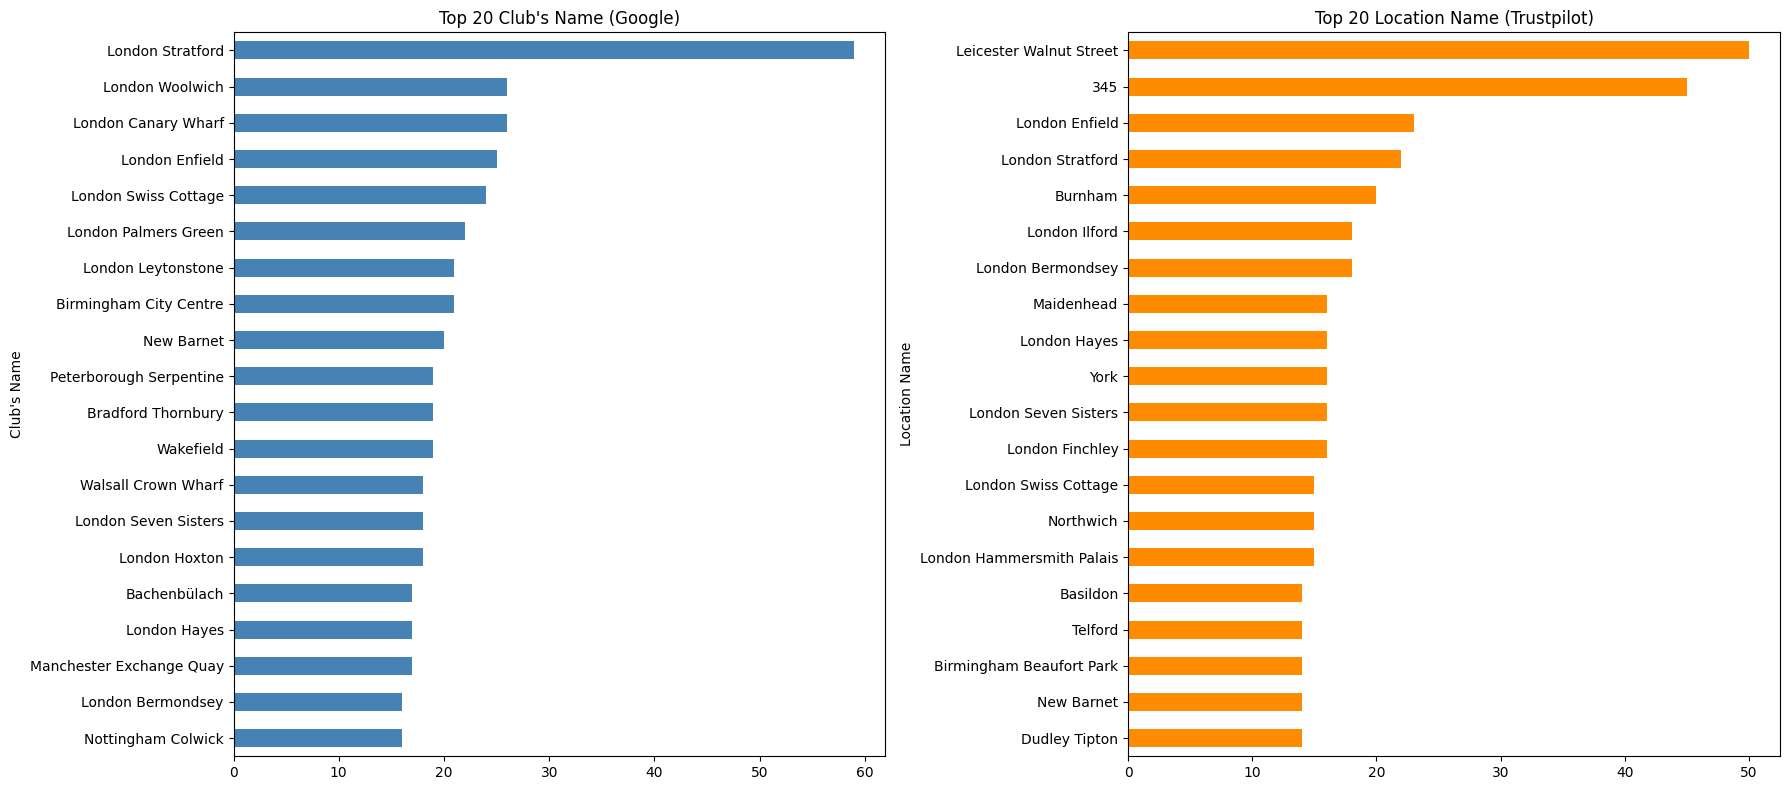

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

negative_google_rev["Club's Name"].value_counts().head(20).plot(kind="barh", ax=axes[0], color="steelblue")
axes[0].set_title("Top 20 Club's Name (Google)")
axes[0].invert_yaxis()

negative_trustp_rev["Location Name"].value_counts().head(20).plot(kind="barh", ax=axes[1], color="darkorange")
axes[1].set_title("Top 20 Location Name (Trustpilot)")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


The top 20 locations appearing in the two datasets show some overlap, particularly for those based in London, while the remaining entries differ across sources.

In [ ]:
negative_t_common_location = negative_t_common_location.rename(columns={
    "Location Name": "Club's Name",
    "Review Created (UTC)": "Creation Date",
    "Review Content": "Comment",
    "Review Stars": "Overall Score"
})

negative_t_common_location["Source"] = "Trustpilot"
negative_g_common_location["Source"] = "Google"

columns_to_keep = ["Club's Name", "Creation Date", "Comment", "Overall Score", "Comment_tk", "Source"]
total_negative_revs = pd.concat([
    negative_g_common_location[columns_to_keep],
    negative_t_common_location[columns_to_keep]
], ignore_index=True)


In [ ]:
total_negative_revs.tail()

Club's Name       Creation Date  \
3942  London East India Dock 2023-05-17 20:13:00   
3943  Colchester Retail Park 2023-05-17 19:13:00   
3944            Cardiff Gate 2023-05-17 17:50:00   
3945    Sheffield Millhouses 2023-05-17 16:40:00   
3946             London Wall 2023-05-17 14:32:00   

                                                Comment  Overall Score  \
3942  There are lot of things to improve  There shou...              1   
3943  Not enough weight plates for benches, spent ha...              2   
3944  I've been a member of this gym for about  2 ye...              2   
3945  Millhouses. Sheffield. Showers not warm enough...              2   
3946  It’s an absolute joke, every week it’s either ...              1   

                                             Comment_tk      Source  
3942  [lot, things, improve, enough, attachments, eq...  Trustpilot  
3943  [enough, weight, plates, benches, ,, spent, ha...  Trustpilot  
3944  ['ve, member, gym, years, 've, noticed, hygien...  Trustpilot  
3945  [millhouses, ., sheffield, ., showers, warm, e...  Trustpilot  
3946  [’, absolute, joke, ,, every, week, ’, either,...  Trustpilot

In [ ]:
total_negative_revs.head()

Club's Name       Creation Date  \
0    Cambridge Leisure Park 2024-05-09 22:48:39   
1        Bristol Union Gate 2024-05-09 21:48:00   
2                New Barnet 2024-05-09 20:16:04   
3  Manchester Cheetham Hill 2024-05-09 17:03:50   
4    Newcastle Eldon Garden 2024-05-09 08:38:07   

                                             Comment  Overall Score  \
0  Too many students from two local colleges go h...              1   
1  (current member)\n\nGym is quite dirty, more o...              1   
2  This gym is way too hot to even workout in. Th...              2   
3  No access for wc 😢.  Empty and no assistance t...              2   
4  After being at this gym for over a year I'm fi...              2   

                                          Comment_tk  Source  
0  [many, students, two, local, colleges, go, lea...  Google  
1  [(, current, member, ), gym, quite, dirty, ,, ...  Google  
2  [gym, way, hot, even, workout, ., windows, ope...  Google  
3  [access, wc, 😢, ., empty, assistance, gain, ac...  Google  
4  [gym, year, 'm, finally, leaving, ., 'm, gutte...  Google

In [ ]:
trustpilot_counts = total_negative_revs[total_negative_revs["Source"] == "Trustpilot"]["Club's Name"].value_counts()
google_counts = total_negative_revs[total_negative_revs["Source"] == "Google"]["Club's Name"].value_counts()

summary = pd.DataFrame({
    "Location": trustpilot_counts.index.union(google_counts.index),
    "Trustpilot Reviews": trustpilot_counts,
    "Google Reviews": google_counts
}).fillna(0)

summary["Total Reviews"] = summary["Trustpilot Reviews"] + summary["Google Reviews"]
summary = summary.sort_values("Total Reviews", ascending=False)

summary.head(20)


Location  Trustpilot Reviews  \
Club's Name                                                                
London Stratford                    London Stratford                22.0   
Leicester Walnut Street      Leicester Walnut Street                50.0   
London Enfield                        London Enfield                23.0   
London Swiss Cottage            London Swiss Cottage                15.0   
Birmingham City Centre        Birmingham City Centre                14.0   
New Barnet                                New Barnet                14.0   
London Bermondsey                  London Bermondsey                18.0   
London Seven Sisters            London Seven Sisters                16.0   
London Hayes                            London Hayes                16.0   
Bradford Thornbury                Bradford Thornbury                14.0   
London Canary Wharf              London Canary Wharf                 6.0   
Walsall Crown Wharf              Walsall Crown Wharf                13.0   
Burnham                                      Burnham                20.0   
London Hammersmith Palais  London Hammersmith Palais                15.0   
London Finchley                      London Finchley                16.0   
London Muswell Hill              London Muswell Hill                13.0   
London Hoxton                          London Hoxton                 8.0   
Maidenhead                                Maidenhead                16.0   
Nottingham Colwick                Nottingham Colwick                10.0   
Birmingham Beaufort Park    Birmingham Beaufort Park                14.0   

                           Google Reviews  Total Reviews  
Club's Name                                               
London Stratford                     59.0           81.0  
Leicester Walnut Street              11.0           61.0  
London Enfield                       25.0           48.0  
London Swiss Cottage                 24.0           39.0  
Birmingham City Centre               21.0           35.0  
New Barnet                           20.0           34.0  
London Bermondsey                    16.0           34.0  
London Seven Sisters                 18.0           34.0  
London Hayes                         17.0           33.0  
Bradford Thornbury                   19.0           33.0  
London Canary Wharf                  26.0           32.0  
Walsall Crown Wharf                  18.0           31.0  
Burnham                              10.0           30.0  
London Hammersmith Palais            14.0           29.0  
London Finchley                      13.0           29.0  
London Muswell Hill                  15.0           28.0  
London Hoxton                        18.0           26.0  
Maidenhead                           10.0           26.0  
Nottingham Colwick                   16.0           26.0  
Birmingham Beaufort Park             12.0           26.0

In [ ]:
top_30_location_list = summary.head(30).index.tolist()

In [ ]:
df_top_30_location = total_negative_revs[total_negative_revs["Club's Name"].isin(top_30_location_list)]

Here the calculation of the top 10 frequent word and the word cloud plot are performed on the 30 locations with the most negative reviews accross the merged dataset

In [ ]:
total_negative_revs_top30loc = total_negative_revs[total_negative_revs['Club\'s Name'].isin(top_30_location_list)].copy()

In [ ]:
total_negative_revs_top30loc.shape

(955, 6)

In [ ]:
extra_stopwords = {'’', "'s","n't"} # I add these extra stopwords cause '’' is not included in the string.punctuation - "'s"
all_words_negative_top_30loc = [word for tokens in total_negative_revs_top30loc["Comment_tk"] for word in tokens if word not in string.punctuation and word.lower() not in extra_stopwords]
freq_dist_neg_merged = FreqDist(all_words_negative_top_30loc)
top_10_words_negative_top_30loc = [word for word, _ in freq_dist_neg_merged.most_common(10)]
print(top_10_words_negative_top_30loc)

['gym', 'equipment', 'staff', 'people', 'one', 'machines', 'get', 'time', 'puregym', 'like']


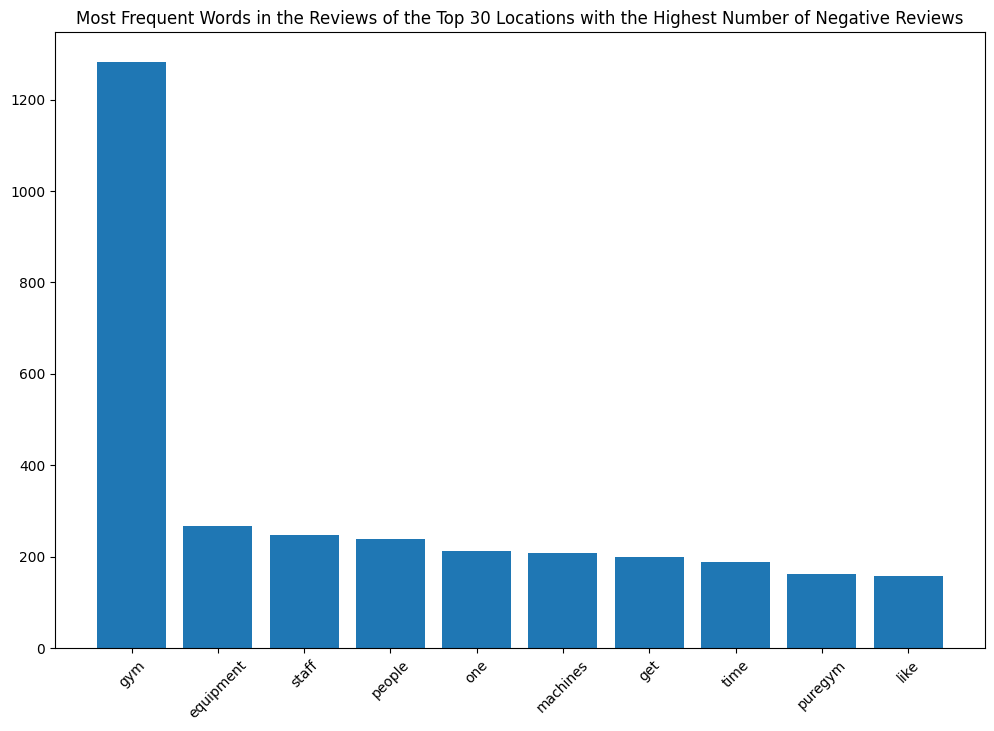

In [ ]:
plt.figure(figsize=(12, 8))
plt.bar(top_10_words_negative_top_30loc, [freq_dist_neg_merged[word] for word in top_10_words_negative_top_30loc])
plt.title('Most Frequent Words in the Reviews of the Top 30 Locations with the Highest Number of Negative Reviews')
plt.tick_params(axis='x', rotation=45)
plt.show()


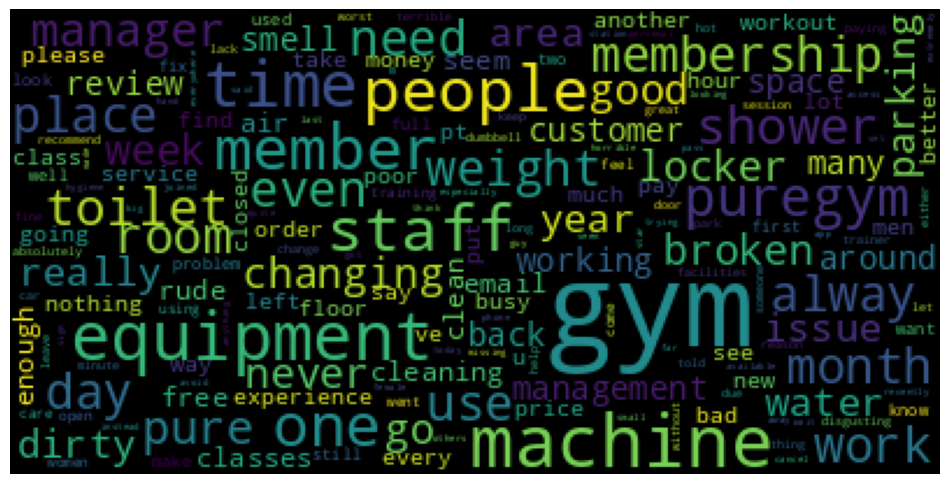

In [ ]:
word_cloud_display(all_words_negative_top_30loc)

The most frequent words and the word cloud for the top 30 locations do not differ significantly from those computed on all negative reviews. Therefore, to understand why these specific locations received a high number of negative reviews, a deeper investigation is required.

Now BERTopic is applied to understand if the location which had the highest number of negative reviews suffer from specific problems.

In [ ]:
total_negative_revs_top30loc = total_negative_revs[total_negative_revs['Club\'s Name'].isin(top_30_location_list)].copy()

total_negative_revs_top30loc['Comment'] = total_negative_revs_top30loc['Comment'].astype(str)

total_negative_revs_top30loc_list = total_negative_revs_top30loc['Comment'].to_list()


In [ ]:
len(total_negative_revs_top30loc_list)

955

In [ ]:
total_negative_revs_top30loc_list_clean = []

for review in total_negative_revs_top30loc_list:
  if review is not None and review != "nan":
    review = review.lower()
    review = re.sub('[^A-Za-z]+', ' ', review)
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(review)

    for w in word_tokens:
      if w in stop_words:
        review = review.replace(" " + w + " ", " ")
    total_negative_revs_top30loc_list_clean.append(review)

In [ ]:
total_negative_revs_top30loc_list_clean[0]

'this gym way hot even workout windows open ac barely works staff near friendly always rude especially men clients mean work '

In [ ]:
model = BERTopic(verbose=True, nr_topics=10, min_topic_size=5)
model.fit(total_negative_revs_top30loc_list_clean)
topic, probabilities = model.transform(total_negative_revs_top30loc_list_clean)
topic = model.reduce_outliers(total_negative_revs_top30loc_list_clean, topic)
model.update_topics(total_negative_revs_top30loc_list_clean, topics=topic)

2025-03-23 11:41:39,687 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/30 [00:00<?, ?it/s]

2025-03-23 11:41:49,115 - BERTopic - Embedding - Completed ✓
2025-03-23 11:41:49,117 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-23 11:41:59,959 - BERTopic - Dimensionality - Completed ✓
2025-03-23 11:41:59,961 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-23 11:41:59,994 - BERTopic - Cluster - Completed ✓
2025-03-23 11:41:59,995 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-03-23 11:42:00,076 - BERTopic - Representation - Completed ✓
2025-03-23 11:42:00,077 - BERTopic - Topic reduction - Reducing number of topics
2025-03-23 11:42:00,089 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-23 11:42:00,130 - BERTopic - Representation - Completed ✓
2025-03-23 11:42:00,131 - BERTopic - Topic reduction - Reduced number of topics from 34 to 10


Batches:   0%|          | 0/30 [00:00<?, ?it/s]

2025-03-23 11:42:00,878 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-03-23 11:42:00,883 - BERTopic - Dimensionality - Completed ✓
2025-03-23 11:42:00,884 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-03-23 11:42:00,910 - BERTopic - Cluster - Completed ✓
100%|██████████| 1/1 [00:00<00:00, 17.45it/s]
2025-03-23 11:42:00,975 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [ ]:
model.get_topic_info()

Topic  Count                             Name  \
0      0    544  0_gym_equipment_machines_people   
1      1    111         1_gym_manager_rude_staff   
2      2     79             2_pin_pass_day_email   
3      3     81  3_broken_machine_machines_water   
4      4     47          4_parking_car_park_free   
5      5     54        5_showers_shower_cold_fix   
6      6     15       6_busy_too_way_overcrowded   
7      7     12              7_nie_si_trenowa_em   
8      8     12            8_door_note_lift_help   

                                      Representation  \
0  [gym, equipment, machines, people, one, always...   
1  [gym, manager, rude, staff, puregym, member, r...   
2  [pin, pass, day, email, membership, gym, work,...   
3  [broken, machine, machines, water, equipment, ...   
4  [parking, car, park, free, gym, fines, fine, r...   
5  [showers, shower, cold, fix, water, gym, pleas...   
6  [busy, too, way, overcrowded, crowded, time, l...   
7  [nie, si, trenowa, em, not, been, ownia, odpow...   
8  [door, note, lift, help, support, people, outs...   

                                 Representative_Docs  
0  [standard pure gym get pay since going last mo...  
1  [avoid gym want exercise friendly clean space ...  
2  [only giving star option zero bought day pass ...  
3  [water fountain broken weeks staff care fix cr...  
4  [get free parking car park would help, i using...  
5  [please fix showers, showers dirty, showers wo...  
6  [too busy, too busy, horrendously overcrowded ...  
7                 [never been, never been, not been]  
8  [one door working people trying leave people t...

In [ ]:
model.get_topic_freq().head(10)

Topic  Count
0      0    544
1      1    111
3      3     81
6      2     79
5      5     54
4      4     47
8      6     15
2      7     12
7      8     12

In [ ]:
topic_freq = model.get_topic_freq()
for _, row in topic_freq.head(10).iterrows():
    topic_id = row['Topic']
    frequency = row['Count']
    name = model.get_topic(topic_id)
    print(f"Topic {topic_id} ({frequency}): {', '.join([word for word, _ in name[:3]])}")

Topic 0 (544): gym, equipment, machines
Topic 1 (111): gym, manager, rude
Topic 3 (81): broken, machine, machines
Topic 2 (79): pin, pass, day
Topic 5 (54): showers, shower, cold
Topic 4 (47): parking, car, park
Topic 6 (15): busy, too, way
Topic 7 (12): nie, si, trenowa
Topic 8 (12): door, note, lift


In [ ]:
topic_freq = model.get_topic_freq()
for _, row in topic_freq.head(2).iterrows():
    topic_id = row['Topic']
    frequency = row['Count']
    name = model.get_topic(topic_id)
    print(f"Topic {topic_id} ({frequency}): {', '.join([word for word, _ in name[:10]])}")

Topic 0 (544): gym, equipment, machines, people, one, always, time, toilets, place, like
Topic 1 (111): gym, manager, rude, staff, puregym, member, reviews, pure, people, would


The two topics identified appear quite distinct. The first and most frequent topic is more general, focusing on overall gym conditions, such as equipment, machines, and cleanliness. This suggests that gyms with a high number of negative reviews often face recurring issues with their facilities. The second topic, on the other hand, is more specific and centers around negative experiences with staff, including mentions of rudeness and poor management, indicating concerns related to customer service.

In [ ]:
model.visualize_topics()

In [ ]:
model.visualize_barchart()

When analyzing the 30 locations that received the highest number of negative reviews, the most prominent topic clearly relates to gym facilities, particularly issues with machines and equipment. Another recurring theme is staff behavior, which also appears consistently across reviews. The remaining topics, however, occur with lower frequency and seem to have had less overall impact. Compared to the analysis conducted on all locations, this more focused subset reveals a shift toward more general and concentrated complaints, whereas the broader dataset includes a wider variety of specific issues, such as problems with air conditioning or the access system.

Furthermore, some of the topics that come up when considering all the locations have disappeared (like air conditioning). This is probably because these problems come up in locations not considered in this analysis.

# Sentiment Analysis

This section focuses on the sentiment analysis of user reviews, aiming to identify the predominant emotions expressed across different locations. Using the pre-trained model bhadresh-savani/bert-base-uncased-emotion, each review is assigned an emotion label. The goal is to explore the overall emotional tone and, in particular, to understand the main drivers that lead to anger in customers — as these negative emotions can be strong indicators of dissatisfaction and potential churn.

In [ ]:
classifier = pipeline("text-classification", model='bhadresh-savani/bert-base-uncased-emotion', return_all_scores=False,truncation=True)

Device set to use cuda:0


In [ ]:
text = "I'm feeling really happy today!"
emotion_label = classifier(text, )

In [ ]:
emotion_label[0]['label']

'joy'

In [ ]:
emotion_label = classifier("I hate this",)
emotion_label[0]['label']

'anger'

In [ ]:
google_review_list = google_rev_clean["Comment"].tolist()

In [ ]:
google_rev_emotion_list = classifier(google_review_list)

In [ ]:
google_rev_emotion_list[120]

{'label': 'joy', 'score': 0.9526857733726501}

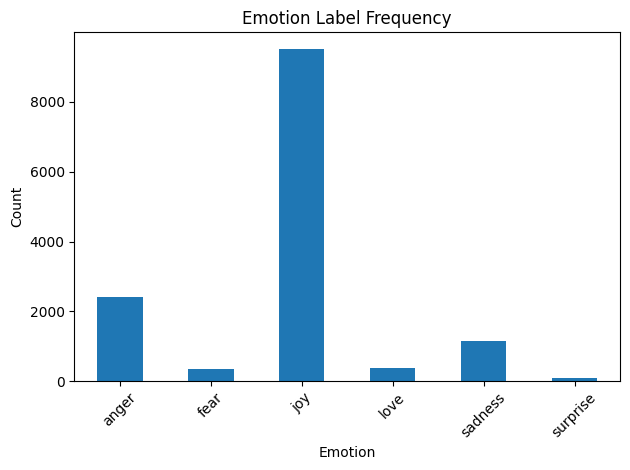

In [ ]:

labels = [d['label'] for d in google_rev_emotion_list]
df = pd.Series(labels).value_counts().sort_index()
df.plot(kind='bar')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Emotion Label Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
trustp_review_list = trustp_rev_clean["Review Content"].tolist()

In [ ]:
trustp_rev_emotion_list = classifier(trustp_review_list)

In [ ]:
trustp_rev_emotion_list[0]

{'label': 'joy', 'score': 0.9923871755599976}

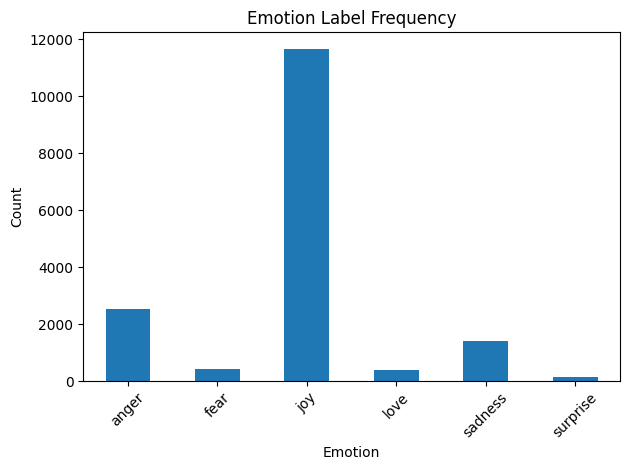

In [ ]:
labels = [d['label'] for d in trustp_rev_emotion_list]
df = pd.Series(labels).value_counts().sort_index()
df.plot(kind='bar')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Emotion Label Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

To have a deeper understanding of the reasons that caused bad reviews, a further analysis has been done by filtering out the reviews where the top emotion was anger.

In [ ]:
anger_trustpilot = sum(1 for d in trustp_rev_emotion_list if d['label'] == 'anger')
perc_anger_trustpilot = (anger_trustpilot / len(trustp_rev_emotion_list)) * 100

anger_google = sum(1 for d in google_rev_emotion_list if d['label'] == 'anger')
perc_anger_google = (anger_google / len(google_rev_emotion_list)) * 100

print(f"The % of reviews with anger as top emotion in the truspilot dataset is: {perc_anger_trustpilot:.2f}%")
print(f"The % of reviews with anger as top emotion in the google dataset is: {perc_anger_google:.2f}%")


The % of reviews with anger as top emotion in the truspilot dataset is: 15.32%
The % of reviews with anger as top emotion in the google dataset is: 17.37%


The distribution of the emotions in the 2 dataset is quite similar.

In [ ]:
# Here the column Emotion is created and added to the 2 dataframes
google_rev_clean['Emotion'] = [d['label'] for d in google_rev_emotion_list]
trustp_rev_clean['Emotion'] = [d['label'] for d in trustp_rev_emotion_list]

In [ ]:
anger_negative_review_list_g = google_rev_clean[(google_rev_clean['Overall Score'] < 3) & (google_rev_clean['Emotion'] == 'anger')]['Comment'].tolist()
anger_negative_review_list_t = trustp_rev_clean[(trustp_rev_clean['Review Stars'] < 3) & (trustp_rev_clean['Emotion'] == 'anger')]['Review Content'].tolist()
# Below the new list of all the negative reviws which have anger as top emotion
anger_negative_review_list = anger_negative_review_list_g + anger_negative_review_list_t

print(len(anger_negative_review_list_g), len(anger_negative_review_list_t), len(anger_negative_review_list))

1193 1579 2772


In [ ]:
anger_negative_review_list[0]

'Too many students from two local colleges go her leave rubbish in changing rooms and sit there like there in a canteen. Been going here for 5 years will cancel my membership and go to gym group. This gym is disgusting students hanging around machines and messing around like there at school. Too over crowded.( And their ceo supports the genocide of civilians by Israel). Disgusting people!!'

Now, BERTopic is reapplied to this list to understand which are the main drivers that lead to customer dissatisfaction and anger. Before running the model, the list has to be clean and the stopwords have to be removed.

In [ ]:
anger_negative_review_list_clean = []

for review in anger_negative_review_list:
  if review is not None and review != "nan":
    review = review.lower()
    review = re.sub('[^A-Za-z]+', ' ', review)
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(review)

    for w in word_tokens:
      if w in stop_words:
        review = review.replace(" " + w + " ", " ")
    anger_negative_review_list_clean.append(review)

In [ ]:
len(anger_negative_review_list_clean)

2772

Language detection was essential at this stage, as BERTopic tends to group reviews written in the same language into the same topics due to strong linguistic similarities

In [ ]:
anger_negative_review_list_clean = [
    rev for rev in anger_negative_review_list_clean
    if len(rev) > 10 and detect(rev) == 'en'
]

In [ ]:
len(anger_negative_review_list_clean)

2349

In [ ]:
model = BERTopic(verbose=True)
model.fit(anger_negative_review_list_clean)
topic, probabilities = model.transform(anger_negative_review_list_clean)
topic = model.reduce_outliers(anger_negative_review_list_clean, topic)
model.update_topics(anger_negative_review_list_clean, topics=topic)

2025-03-23 12:59:38,137 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/74 [00:00<?, ?it/s]

2025-03-23 12:59:40,440 - BERTopic - Embedding - Completed ✓
2025-03-23 12:59:40,440 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-23 12:59:48,306 - BERTopic - Dimensionality - Completed ✓
2025-03-23 12:59:48,309 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-23 12:59:48,430 - BERTopic - Cluster - Completed ✓
2025-03-23 12:59:48,436 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-23 12:59:48,590 - BERTopic - Representation - Completed ✓


Batches:   0%|          | 0/74 [00:00<?, ?it/s]

2025-03-23 12:59:50,414 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-03-23 12:59:50,422 - BERTopic - Dimensionality - Completed ✓
2025-03-23 12:59:50,423 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-03-23 12:59:50,528 - BERTopic - Cluster - Completed ✓
100%|██████████| 1/1 [00:00<00:00,  3.91it/s]
2025-03-23 12:59:50,800 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [ ]:
model.get_topic_info()

Topic  Count                                Name  \
0       0    210                 0_pass_pin_day_code   
1       1    113    1_class_classes_booked_cancelled   
2       2    138         2_rude_staff_manager_member   
3       3     96          3_fee_joining_code_charged   
4       4    103      4_weights_equipment_people_gym   
5       5    110   5_membership_payment_cancel_month   
6       6     79         6_closed_open_gym_christmas   
7       7     73         7_cold_showers_water_shower   
8       8     59             8_parking_car_park_fine   
9       9     96     9_toilets_changing_toilet_rooms   
10     10    150         10_gym_people_members_staff   
11     11     84          11_showers_shower_cold_hot   
12     12     58          12_music_loud_classes_hear   
13     13     61         13_air_conditioning_ac_heat   
14     14     64     14_rude_staff_manager_customers   
15     15     90       15_access_membership_pay_gyms   
16     16     63  16_smell_ventilation_smelly_smells   
17     17     61       17_crowded_too_busy_equipment   
18     18     63     18_gym_layout_equipment_benches   
19     19     63      19_phones_people_kids_machines   
20     20     51       20_machines_machine_lot_order   
21     21     43       21_lockers_locker_stolen_lock   
22     22     51       22_cancel_debit_direct_refund   
23     23     36       23_worst_ever_incompetent_gym   
24     24     58       24_email_reply_contact_emails   
25     25     46          25_help_staff_went_minutes   
26     26     31         26_machines_enough_many_too   
27     27     27    27_cleaning_sweat_clean_stations   
28     28     33          28_reviews_broken_gym_pure   
29     29     29           29_water_machine_pay_last   
30     30     29                 30_app_use_get_live   
31     31     31  31_cleaning_stations_towel_removed   
32     32     21          32_wifi_signal_internet_fi   
33     33     29        33_suspended_account_pay_dkk   

                                       Representation  \
0   [pass, pin, day, code, get, access, bought, wo...   
1   [class, classes, booked, cancelled, book, inst...   
2   [rude, staff, manager, member, gym, personal, ...   
3   [fee, joining, code, charged, promo, discount,...   
4   [weights, equipment, people, gym, busy, enough...   
5   [membership, payment, cancel, month, customer,...   
6   [closed, open, gym, christmas, opening, th, da...   
7   [cold, showers, water, shower, freezing, warm,...   
8   [parking, car, park, fine, fines, free, reg, f...   
9   [toilets, changing, toilet, rooms, room, disgu...   
10  [gym, people, members, staff, equipment, place...   
11  [showers, shower, cold, hot, water, gym, tempe...   
12  [music, loud, classes, hear, headphones, noise...   
13  [air, conditioning, ac, heat, con, hot, summer...   
14  [rude, staff, manager, customers, extremely, p...   
15  [access, membership, pay, gyms, month, gym, pl...   
16  [smell, ventilation, smelly, smells, air, stin...   
17  [crowded, too, busy, equipment, many, enough, ...   
18  [gym, layout, equipment, benches, space, cardi...   
19  [phones, people, kids, machines, equipment, si...   
20  [machines, machine, lot, order, legs, handles,...   
21  [lockers, locker, stolen, lock, stole, bag, st...   
22  [cancel, debit, direct, refund, membership, cu...   
23  [worst, ever, incompetent, gym, edith, puregym...   
24  [email, reply, contact, emails, response, serv...   
25  [help, staff, went, minutes, tour, said, gym, ...   
26  [machines, enough, many, too, busy, people, no...   
27  [cleaning, sweat, clean, stations, machines, w...   
28  [reviews, broken, gym, pure, aircon, cleaners,...   
29  [water, machine, pay, last, hot, yanga, workin...   
30  [app, use, get, live, family, process, chat, c...   
31  [cleaning, stations, towel, removed, spray, st...   
32  [wifi, signal, internet, fi, wi, works, connec...   
33  [suspended, account, pay, dkk, amount, payment...   

                                  Representativ

In [ ]:
model.get_topic_freq().head(10)

Topic  Count
8       0    210
4      10    150
3       2    138
6       1    113
20      5    110
2       4    103
28      3     96
7       9     96
17     15     90
15     11     84

In [ ]:
topic_freq = model.get_topic_freq()
for _, row in topic_freq.head(10).iterrows():
    topic_id = row['Topic']
    frequency = row['Count']
    name = model.get_topic(topic_id)
    print(f"Topic {topic_id} ({frequency}): {', '.join([word for word, _ in name[:3]])}")

Topic 0 (210): pass, pin, day
Topic 10 (150): gym, people, members
Topic 2 (138): rude, staff, manager
Topic 1 (113): class, classes, booked
Topic 5 (110): membership, payment, cancel
Topic 4 (103): weights, equipment, people
Topic 3 (96): fee, joining, code
Topic 9 (96): toilets, changing, toilet
Topic 15 (90): access, membership, pay
Topic 11 (84): showers, shower, cold


In [ ]:
topic_freq = model.get_topic_freq()
for _, row in topic_freq.head(2).iterrows():
    topic_id = row['Topic']
    frequency = row['Count']
    name = model.get_topic(topic_id)
    print(f"Topic {topic_id} ({frequency}): {', '.join([word for word, _ in name[:10]])}")

Topic 0 (210): pass, pin, day, code, get, access, bought, work, sent, paid
Topic 10 (150): gym, people, members, staff, equipment, place, weights, one, training, around


In [ ]:
model.visualize_topics()

The clusters reveal several key topics that have triggered anger among customers, particularly issues related to gym access. In the lower right quadrant, for instance, multiple topics emerge around memberships, access problems, cancellations, and the difficulty of reaching staff for assistance. Another prominent cluster is centered on negative experiences with staff behavior, including rudeness and lack of support. A further group of topics relates to facilities, such as showers and air conditioning. Overall, the clusters show some semantic overlap but remain well-defined, as they often pertain to the same area of the customer experience while stemming from distinct issues.

In [ ]:
model.visualize_barchart()

In [ ]:
model.visualize_heatmap()

Topic 0 (210): pass, pin, day

Topic 10 (150): gym, people, members

Topic 2 (138): rude, staff, manager

Topic 1 (113): class, classes, booked

Topic 5 (110): membership, payment, cancel

Topic 4 (103): weights, equipment, people

Topic 3 (96): fee, joining, code

Topic 9 (96): toilets, changing, toilet

Topic 15 (90): access, membership, pay

Topic 11 (84): showers, shower, cold

The analysis of reviews filtered by anger reveals a sharper focus on issues that trigger strong emotional responses, distinguishing them from the broader dissatisfaction patterns observed earlier. The most prominent topics—such as problems with access passes and PINs (Topic 0), difficulties in booking classes (Topic 1), and rude staff or unhelpful managers (Topic 2)—highlight specific friction points that go beyond general inconvenience. These experiences, like paying for access and being unable to enter the gym or facing recurring issues with class scheduling, can generate frustration and a sense of unfair treatment. Such moments are more likely to provoke emotional reactions and ultimately drive customer churn. Other topics, including poor hygiene in showers and changing rooms (Topic 11 and 9), equipment-related complaints, and unexpected fees, further reflect how operational shortcomings can escalate into anger when they interfere with basic expectations of service. Overall, these insights emphasize the importance of resolving critical access and communication issues to reduce customer attrition.

# LLM Model

This section leverages a pre-trained Large Language Model (LLM) from Hugging Face to perform topic modeling on customer reviews. The goal is to uncover key themes and patterns within the feedback, enabling a deeper understanding of user concerns and identifying potential operational or service-related issues that may drive dissatisfaction or churn.

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-4-mini-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-4-mini-instruct")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.50k [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/10.9k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-4-mini-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/54.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-4-mini-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.77G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.93k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/3.91M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/15.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

In [ ]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

Device set to use cuda


In [ ]:
generation_args = {
    "max_new_tokens": 1000,
    "return_full_text": False,
    "temperature": 0.0,
    "do_sample": False,
}

In [ ]:
messages_1 = [
    {"role": "system", "content": "You are a data analyst specialized in extracting actionable topics from customer reviews in the fitness industry. Your goal is to identify concrete issues that can help improve operations. Return them in a numbered list format, with each one on a new line."},
    {"role": "user", "content": "In the following customer review, pick out the main 3 topics. Return them in a numbered list format, with each one on a new line: The showers are disgusting."},
    {"role": "assistant",  "content": "1. Shower cleanliness\n2. Poor hygiene\n3. Lack of maintenance"},
    {"role": "user", "content": "Extract the top 3 main topics from this review and return in a numbered list format, with each one on a new line: I have paid my membership but I can't access the gym, I am still waiting on a code."}
]



In [ ]:
output = pipe(messages_1, **generation_args)

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [ ]:
output

[{'generated_text': '1. Membership access issues\n2. Delayed code delivery\n3. Technical problems with gym access'}]

In [ ]:
print(output[0]['generated_text'])

1. Membership access issues
2. Delayed code delivery
3. Technical problems with gym access


In [ ]:
negative_review_g_list = google_rev_clean[google_rev_clean["Overall Score"] < 3]["Comment"].tolist()
negative_review_t_list = trustp_rev_clean[trustp_rev_clean["Review Stars"] < 3]["Review Content"].tolist()

total_negative_review_list = negative_review_g_list + negative_review_t_list

In [ ]:
total_negative_review_list[0]

'Too many students from two local colleges go her leave rubbish in changing rooms and sit there like there in a canteen. Been going here for 5 years will cancel my membership and go to gym group. This gym is disgusting students hanging around machines and messing around like there at school. Too over crowded.( And their ceo supports the genocide of civilians by Israel). Disgusting people!!'

In [ ]:
topics_llm = []
print(len(total_negative_review_list))

for idx, review in enumerate(total_negative_review_list[start_index:], start=start_index):
  if len(str(review)) < 1000:
    messages_2 = [
      {"role": "system", "content": "You are a data analyst specialized in extracting actionable topics from customer reviews in the fitness industry. Your goal is to identify concrete issues that can help improve operations. Return them in a numbered list format, with each one on a new line."},
      {"role": "user", "content": "In the following customer review, pick out the main 3 topics. Return them in a numbered list format, with each one on a new line: The showers are disgusting."},
      {"role": "assistant",  "content": "1. Shower cleanliness\n2. Poor hygiene\n3. Lack of maintenance"},
      {"role": "user", "content": f"In the following customer review, pick out the main 3 topics. Return them in a numbered list format, with each one on a new line: {review}"}
    ]
    output = pipe(messages_2, **generation_args)

    text = output[0]['generated_text']
    topic_list = [line.strip() for line in text.split('\n') if line.strip()]
    topics_llm.append(topic_list)

    if (idx + 1) % 1000 == 0:
      print(f'number of reviews computed: {idx - start_index}')




6293


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


number of reviews computed: 47
number of reviews computed: 1047
number of reviews computed: 2047
number of reviews computed: 3047
number of reviews computed: 4047
number of reviews computed: 5047


The 'print' above started at review n° 952 due to notebook crash.

In [ ]:
topic_string_array = [item for row in topics_llm for item in row]

In [ ]:
topic_string_array[30]

'2. Staff behavior'

In [ ]:
topic_string_array = [re.sub(r'^\d+\.\s*', '', topic) for topic in topic_string_array]

In [ ]:
topic_string_array[30]

'Staff behavior'

Now the BERTopic model is reapplied to this list output of the LLM, to catch the main topics extracted.

In [ ]:
topic_string_array_clean = []

for review in topic_string_array:
  if review is not None and review != "nan":
    review = review.lower()
    review = re.sub('[^A-Za-z]+', ' ', review)
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(review)

    for w in word_tokens:
      if w in stop_words:
        review = review.replace(" " + w + " ", " ")
    topic_string_array_clean.append(review)

In [ ]:
model = BERTopic(verbose=True)
model.fit(topic_string_array_clean)
topic, probabilities = model.transform(topic_string_array_clean)
topic = model.reduce_outliers(topic_string_array_clean, topic)
model.update_topics(topic_string_array_clean, topics=topic)

2025-03-23 18:01:01,389 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/584 [00:00<?, ?it/s]

2025-03-23 18:01:08,961 - BERTopic - Embedding - Completed ✓
2025-03-23 18:01:08,962 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-23 18:01:56,187 - BERTopic - Dimensionality - Completed ✓
2025-03-23 18:01:56,189 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-23 18:02:00,929 - BERTopic - Cluster - Completed ✓
2025-03-23 18:02:00,940 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-23 18:02:01,493 - BERTopic - Representation - Completed ✓


Batches:   0%|          | 0/584 [00:00<?, ?it/s]

2025-03-23 18:02:07,771 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-03-23 18:02:07,837 - BERTopic - Dimensionality - Completed ✓
2025-03-23 18:02:07,839 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-03-23 18:02:08,883 - BERTopic - Cluster - Completed ✓
100%|██████████| 3/3 [00:00<00:00, 69.70it/s]
2025-03-23 18:02:09,151 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [ ]:
model.get_topic_info()

Topic  Count                                               Name  \
0       -1      5                  -1_diverse_forced_renewals_tastes   
1        0    469                       0_service_customer_poor_star   
2        1    234                   1_overcrowding_properly_train_pm   
3        2    170  2_overcrowding_oversubscription_traffic_gather...   
4        3    151          3_insufficient_equipment_variety_quantity   
..     ...    ...                                                ...   
545    544     17            544_policy_cancellation_unfair_policies   
546    545     18          545_fountain_station_hydration_irrigation   
547    546     14           546_induction_requirement_arranging_hold   
548    547     13  547_inaccessibility_validity_desired_disappear...   
549    548     11             548_repairs_switches_malfunction_parts   

                                        Representation  \
0    [diverse, forced, renewals, tastes, trustworth...   
1    [service, customer, poor, star, rating, saturd...   
2    [overcrowding, properly, train, pm, crowded, g...   
3    [overcrowding, oversubscription, traffic, gath...   
4    [insufficient, equipment, variety, quantity, p...   
..                                                 ...   
545  [policy, cancellation, unfair, policies, membe...   
546  [fountain, station, hydration, irrigation, wip...   
547  [induction, requirement, arranging, hold, repe...   
548  [inaccessibility, validity, desired, disappear...   
549  [repairs, switches, malfunction, parts, replac...   

                                   Representative_Docs  
0    [broken toilets, poor maintenance facilities t...  
1    [poor customer service, poor customer service,...  
2           [overcrowding, overcrowding, overcrowding]  
3           [overcrowding, overcrowding, overcrowding]  
4    [insufficient equipment, insufficient equipmen...  
..                                                 ...  
545  [membership cancellation policy, membership ca...  
546  [water fountain hygiene, water fountain mainte...  
547  [poor induction experience, induction process,...  
548  [inaccessibility gym facilities, inaccessibili...  
549  [equipment malfunction lack repairs, equipment...  

[550 rows x 5 columns]

In [ ]:
topic_freq = model.get_topic_freq()
for _, row in topic_freq.head(10).iterrows():
    topic_id = row['Topic']
    frequency = row['Count']
    name = model.get_topic(topic_id)
    print(f"Topic {topic_id} ({frequency}): {', '.join([word for word, _ in name[:3]])}")

Topic 0 (469): service, customer, poor
Topic 1 (234): overcrowding, properly, train
Topic 2 (170): overcrowding, oversubscription, traffic
Topic 3 (151): insufficient, equipment, variety
Topic 4 (133): communication, service, customer
Topic 6 (124): malfunction, lift, equipment
Topic 5 (123): communication, lack, barriers
Topic 8 (116): weight, weights, leg
Topic 7 (115): dissatisfaction, churn, customer
Topic 10 (115): soundproofing, facilities, unattended


The results obtained in this step are different with respect to the BERTopic applied before on the negative reviews, due to a different analytical approach:

1. In the first case, BERTopic was applied directly to the raw text of negative reviews, allowing the model to identify topics based on patterns of word co-occurrence in the original language used by customers. This approach tends to produce topics that reflect specific, concrete issues such as faulty equipment, poor air conditioning, or unclean facilities.

2. In the second case, the input to BERTopic consisted of summarized topics extracted from each review using a large language model (LLM). **This pre-processing step introduced a layer of abstraction, as the LLM distilled the original content into higher-level thematic representations**. For instance, rather than isolating specific complaints like broken machines, lack of variety, or long waits, the LLM might infer a broader issue such as "poor equipment maintenance and availability." As a result, BERTopic operated on input that was already semantically condensed, leading to the emergence of broader, more conceptual topics such as customer dissatisfaction, overcrowding, or poor communication.

This shift also affected the level of granularity: while the first approach surfaced concrete and localized issues, the second approach highlighted generalized causes and systemic perceptions.










In [ ]:
topic_freq = model.get_topic_freq()
for _, row in topic_freq.head(2).iterrows():
    topic_id = row['Topic']
    frequency = row['Count']
    name = model.get_topic(topic_id)
    print(f"Topic {topic_id} ({frequency}): {', '.join([word for word, _ in name[:10]])}")

Topic 0 (469): service, customer, poor, star, rating, saturdays, moving, sellers, arrogant, acoustics
Topic 1 (234): overcrowding, properly, train, pm, crowded, gym, facilities, issues, inadequate, maintenance


In [ ]:
topic_string_array

['Overcrowding',
 'Poor hygiene and cleanliness',
 'Unprofessional behavior and management issues',
 'Cleanliness of the gym',
 'Lack of soap in the bathroom',
 'Overcrowding after 3pm',
 'Poor ventilation in the gym',
 'Positive aspects: location and bring your buddy program',
 'Lack of proper instruction and guidance',
 'Inadequate staff interaction and assistance',
 'Potential for self-injury due to lack of knowledge and supervision',
 'Inadequate temperature control',
 'Poor air conditioning maintenance',
 'Unfriendly staff attitude',
 'Lack of access to facilities',
 'Inadequate assistance or support',
 'Security system issues (forgotten pin)',
 'Overcrowding',
 'Insufficient equipment',
 'Lack of air conditioning and gym closure',
 'Insufficient equipment',
 'Poor management',
 'Lack of facilities improvement',
 'Air-conditioning malfunction',
 'Inadequate climate control',
 'Equipment failure',
 'Inadequate assistance for new members',
 'Lack of gym etiquette',
 'Poor hygiene an

To further interpret the recurring issues identified in the reviews, the phi-4  large language model (LLM) was used to condense and group the main topics into broader themes. Based on these aggregated insights, a set of proposed improvements is provided to address the underlying problems and enhance the overall customer experience.

Due to lack of RAM resources, the topics considered are just a subsample of all the topics previously obtained thanks to the LLM.

In [ ]:
import random

sampled_topics = random.sample(topic_string_array, 6000)

A single shot prompt approach is used to guide the LLM to provide the output in the expected content and format.

In [ ]:
messages_3 = [
    {"role": "system", "content": "You are a data analyst specialized in identifying solutions to problems highlighted in negative customer reviews in the fitness industry. You are provided with a list of all negative comments from customer reviews. Your goal is to detect recurring issues and, for the most frequent topics, provide actionable insights in the form of specific recommendations. You should return these in a numbered list"},
    {"role": "user", "content": "In the following list containing the main extracted topics from customer reviews, group or compress similar topics and return them with actionable insights in a numbered list: ['Gym layout and capacity', 'Parking availability and management', 'Membership transfer and gym comparison', 'Gym layout and space management', 'Safety concerns during peak times', 'Age verification and age-appropriate access', 'Insufficient parking', 'Overcrowding']"},
    {"role": "assistant", "content": "1. Gym layout and space management: \n    - Redesign workout areas to improve equipment distribution and optimize space \n    - Reduce the number of unused machines  \n2. Overcrowding and safety concerns during peak times: \n    - Introduce a real-time occupancy system  \n    - consider time slot limits to ensure safety and member comfort. \n3. Parking availability and management: \n    - Expand available parking if possible \n    -  Partner with nearby lots to reduce congestion and improve member experience."},
    {"role": "user", "content": f"In the following list containing the main extracted topics from negative customer reviews, group the main topics in a numbered list and provide 3 actionable insights for each one: {sampled_topics}"},
]

In [ ]:
output = pipe(messages_3, **generation_args)


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [ ]:
len(topic_string_array)

18688

In [ ]:
insights = output[0]['generated_text']

In [ ]:
print(insights)

1. Overcrowding and lack of space:
   - Implement a reservation system to manage peak time attendance and ensure adequate space for all members.
   - Expand gym facilities or add additional workout areas to accommodate more members.
   - Offer off-peak hour classes to distribute the customer load throughout the day.

2. Poor customer service and communication:
   - Provide comprehensive training for staff to improve customer interaction and problem-solving skills.
   - Establish clear communication channels for members to reach out to customer service, such as a dedicated phone line, email, and chat support.
   - Regularly update members on gym policies, class schedules, and any changes through multiple platforms (website, app, email).

3. Inadequate facilities and equipment maintenance:
   - Increase the frequency of equipment maintenance checks and repairs to ensure all machines are in good working condition.
   - Invest in a better cleaning and maintenance schedule to keep the gym a

The analysis of the main topics revealed a range of recurring concerns among gym members, primarily related to overcrowding, service quality, facility maintenance, and communication. Based on these findings, targeted recommendations were developed to address operational inefficiencies, improve the customer experience, and better align services with members’ expectations.

# Gensim

In this section, Gensim is used to perform topic modeling on the review dataset. Gensim is a Python library that implements Latent Dirichlet Allocation (LDA), a probabilistic model that identifies latent topics in a collection of documents by analyzing word co-occurrence patterns. This approach helps uncover the underlying themes discussed across the reviews.

Here a specific preprocess function is developed to prepare the text for the LDA. Respect to the previous preprocess, the lemmatization is applied.

In [ ]:
def preprocess_text_LDA(text):
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    punctuation_extended = set(string.punctuation) | {"’", "‘", "`", "´", "“", "”", "''", "``", "'"}

    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if word not in punctuation_extended]
    tokens = [word for word in tokens if word != "n't"]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

In [ ]:
google_rev_clean['Comment_LDA'] = google_rev_clean['Comment'].apply(preprocess_text_LDA)

In [ ]:
trustp_rev_clean['Comment_LDA'] = trustp_rev_clean['Review Content'].apply(preprocess_text_LDA)

In [ ]:
print(google_rev_clean.loc[12,'Comment_LDA'])
print(google_rev_clean.loc[12,'Comment'])

["'s", 'nice', 'experience', 'get', 'exercise', 'done', 'via', 'modern', 'facility', 'provided', 'puregym']
It's has been a nice experience to get some exercise done via the modern facilities provided by PureGym.


In [ ]:
negative_rev_g_LDA_list = google_rev_clean[google_rev_clean['Overall Score'] < 3]['Comment_LDA'].copy().tolist()
negative_rev_t_LDA_list  = trustp_rev_clean[trustp_rev_clean['Review Stars'] < 3]['Comment_LDA'].copy().tolist()

In [ ]:
negative_rev_t_LDA_list[0]

['extremely', 'busy', 'fresh', 'air']

In [ ]:
negative_rev_total_LDA_list = negative_rev_g_LDA_list + negative_rev_t_LDA_list

In [ ]:
len(negative_rev_total_LDA_list)

6293

Non-English reviews were removed, as Gensim incorrectly grouped them into mixed-language topics.










In [ ]:
en_negative_rev_total_LDA_list = [
    rev for rev in negative_rev_total_LDA_list
    if len(rev) > 10 and detect(" ".join(rev)) == 'en'
]

In [ ]:
len(en_negative_rev_total_LDA_list)

4298

In [ ]:
dictionary = corpora.Dictionary(en_negative_rev_total_LDA_list)
dictionary.filter_extremes(no_below=3, no_above=0.5)

In [ ]:
dictionary[150]

'morning'

In [ ]:
corpus = [dictionary.doc2bow(doc) for doc in en_negative_rev_total_LDA_list]
num_topics = 10
passes = 20
lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=passes)

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic))

Topic: 0 
Words: 0.150*"class" + 0.030*"music" + 0.024*"instructor" + 0.019*"time" + 0.014*"loud" + 0.013*"bike" + 0.012*"cancelled" + 0.012*"booked" + 0.011*"spin" + 0.009*"place"
Topic: 1 
Words: 0.024*"email" + 0.020*"membership" + 0.019*"day" + 0.017*"month" + 0.017*"service" + 0.016*"get" + 0.015*"customer" + 0.013*"time" + 0.011*"tried" + 0.010*"still"
Topic: 2 
Words: 0.020*"member" + 0.010*"time" + 0.009*"people" + 0.009*"pt" + 0.008*"manager" + 0.008*"review" + 0.008*"year" + 0.007*"like" + 0.007*"one" + 0.007*"staff"
Topic: 3 
Words: 0.022*"cleaning" + 0.021*"parking" + 0.016*"people" + 0.014*"station" + 0.013*"staff" + 0.012*"park" + 0.012*"equipment" + 0.012*"member" + 0.012*"weight" + 0.010*"place"
Topic: 4 
Words: 0.032*"member" + 0.030*"staff" + 0.020*"manager" + 0.016*"rude" + 0.014*"locker" + 0.013*"said" + 0.011*"friend" + 0.011*"one" + 0.011*"pure" + 0.010*"personal"
Topic: 5 
Words: 0.090*"machine" + 0.030*"broken" + 0.024*"time" + 0.022*"one" + 0.022*"equipment" + 

The Gensim LDA model identifies topics centered around specific themes, such as classes and instructors (Topic 0), membership and customer service (Topic 1), and facility-related issues like cleaning and equipment (Topic 3 and Topic 5). Each topic is defined by the most frequent words, providing insights into the common themes of the dataset.

In contrast, BERTopic applies a different analytical approach by leveraging pre-trained transformer embeddings, which capture more nuanced semantic relationships between words. This allows BERTopic to generate topics that are more contextually coherent and distinct, as seen in groupings like "air," "conditioning," and "con," which are more meaningfully related compared to the simpler word clusters found in Gensim.

Overall, Gensim offers a more traditional approach to topic modeling, focusing on word co-occurrence, while BERTopic captures richer semantic patterns, making it more suited for generating topics with deeper contextual relevance.

In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis


pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

# Conclusion

In conclusion, BERTopic was applied in three different ways: on raw reviews, on anger-filtered reviews via sentiment analysis, and on summaries generated by a large language model (LLM).
1. When applied to raw reviews, BERTopic effectively identified concrete, recurring issues behind customer dissatisfaction, such as equipment problems or staff behavior.
2. Filtering for angry reviews led to even more specific and emotionally charged topics, highlighting issues that clearly triggered strong negative reactions.
3. When using LLM-generated summaries as input, BERTopic worked on semantically condensed content, leading to more abstract and high-level topics—such as poor communication or overall dissatisfaction—rather than isolated complaints. This preprocessing step allowed the model to capture broader themes, and the LLM itself provided actionable recommendations to address these underlying issues.
   
Overall, the combined approach proved valuable in uncovering both granular pain points and high-level themes, while Gensim-based modeling was less informative in comparison.